# DC Inside 오버워치 갤러리 데이터 EDA

## 절차
1. 데이터 정제
- csv 세로로 병합
- 제목+본문이 이어진 한 문장인 경우가 많아 둘을 병합 후 제목열, 본문열 드랍
- 댓글을 따로 떼서 user, text, date에 맞게 병합
- 조회수, 댓글수 int로 변환

2. 활동 패턴 분석
- 시간대·요일별 활동량
    - 글/댓글 수 시각화

3. 컨텐츠 성격 분석
- 게시글 유형 분포
    - post_type 별 비율
- 조회수, 반응 분석
    - 조회수(view_cnt)와 prefer/nonprefer의 상관관계 분석
    - 댓글 수(review_cnt)와 반응 비교

4. 텍스트 분석
- 긍/부정 키워드 워드클라우드

5. 상호작용 분석
- 글/댓글 연결 구조 분석
- 댓글 상위 1% 글과 나머지 글의 조회수/좋아요 지표 비교
- 1% 글에서 상위 키워드 20개 뽑기
- 특정 시점에 급증한 키워드/주제 탐색

In [1]:
import pandas as pd
import re
from datetime import datetime
import seaborn as sns
from collections import Counter
import time
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TextClassificationPipeline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. 데이터 정제

In [26]:
# csv 세로로 병합

# 파일 읽기
files = ["오버워치갤반응1.csv", "오버워치갤반응2.csv", "오버워치갤반응3.csv"]
df_list = [pd.read_csv(f) for f in files]

# 세로 병합
gall = pd.concat(df_list, ignore_index=True)

In [27]:
# 제목 + 본문 결합
gall['full_text'] = (gall['title'].fillna('') + ' ' + gall['text'].fillna('')).str.strip()

In [28]:
# 제목 + 본문열 드롭
gall.drop(columns=['title', 'text'], inplace=True)

In [29]:
# 댓글을 full_text에 병합하기

# 원본 post 부분
post_df = gall[['href', 'post_type', 'post_user', 'date', 'view_cnt', 'prefer', 'nonprefer', 'review_cnt', 'full_text']].copy()

In [30]:
# 댓글 부분 나누고 post 부분에 맞게 컬럼명 바꾸기
review_df = gall[['href', 'post_type', 'review_user', 'review_date', 'view_cnt', 'prefer', 'nonprefer', 'review_cnt', 'review_text']].copy()
review_df.rename(columns={
    'review_user': 'post_user',
    'review_date': 'date',
    'review_text': 'full_text'
}, inplace=True)

In [31]:
# 댓글은 post_type을 [댓글]로 변경
review_df['post_type'] = '[댓글]'

In [32]:
# 두 DF 세로 병합
merged_df = pd.concat([post_df, review_df], ignore_index=True)

In [33]:
# 인덱스 리셋
merged_df.reset_index(drop=True, inplace=True)

In [34]:
# full_text 기준 중복 제거 (첫 번째 것만 남김)
merged_df = merged_df.drop_duplicates(subset=['full_text'], keep='first').reset_index(drop=True)

In [35]:
# 조회수 숫자만 남기고 int 변환
merged_df['view_cnt'] = (
    merged_df['view_cnt']
    .astype(str)
    .str.replace('조회 ', '', regex=False)
    .astype(int)
)

# 댓글수 숫자만 남기고 int 변환
merged_df['review_cnt'] = (
    merged_df['review_cnt']
    .astype(str)
    .str.replace('댓글 ', '', regex=False)
    .astype(int)
)

In [36]:
merged_df.to_csv('22-1. 감성분석용 갤러리데이터.csv', index=False, encoding='utf-8-sig')

## 2. 시간대/ 요일별 활동량

### 날짜 변환하기

In [37]:
df = pd.read_csv('22-1. 감성분석용 갤러리데이터.csv', encoding='utf-8-sig')

In [38]:
# 댓글 여부 플래그
df['is_comment'] = df['post_type'].eq('[댓글]')

# 원글(href)의 연도 추출
post_year_map = (
    df.loc[~df['is_comment'] & df['date'].astype(str).str.contains(r'\d{4}\.'),
           ['href', 'date']]
      .assign(year=lambda x: x['date'].str.extract(r'(\d{4})').astype(int))
      .groupby('href')['year']
      .agg(lambda s: s.mode().iloc[0] if not s.mode().empty else s.iloc[0])
      .to_dict()
)

# 날짜 변환 함수
def parse_date(row):
    s = str(row['date'])
    if re.search(r'\d{4}\.\d{2}\.\d{2}', s):  # 연도 있음
        return pd.to_datetime(s, errors='coerce')
    # 연도 없음 → href에서 연도 보정
    base_year = post_year_map.get(row['href'], datetime.now().year)
    return pd.to_datetime(f"{base_year}.{s}", errors='coerce')

df['date_dt'] = df.apply(parse_date, axis=1)
df = df.dropna(subset=['date_dt']).reset_index(drop=True)

### 시간대, 요일 보정

In [39]:
# 시간대, 요일
df['hour'] = df['date_dt'].dt.hour
df['weekday'] = df['date_dt'].dt.weekday  # 0=Mon
weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['weekday_name'] = df['weekday'].map(weekday_map)

In [40]:
# 시간대별 글/댓글 수
counts_by_hour = df.groupby(['hour','is_comment']).size().unstack(fill_value=0)
counts_by_hour.columns = ['posts','comments']

# 요일별 글/댓글 수
counts_by_weekday = df.groupby(['weekday_name','is_comment']).size().unstack(fill_value=0)
counts_by_weekday.columns = ['posts','comments']
counts_by_weekday = counts_by_weekday.reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

# 요일 × 시간대 집계 (글+댓글 전체)
heatmap_data = (
    df.groupby(['weekday_name', 'hour'])
      .size()
      .unstack(fill_value=0)
      .reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun']))

### 시각화

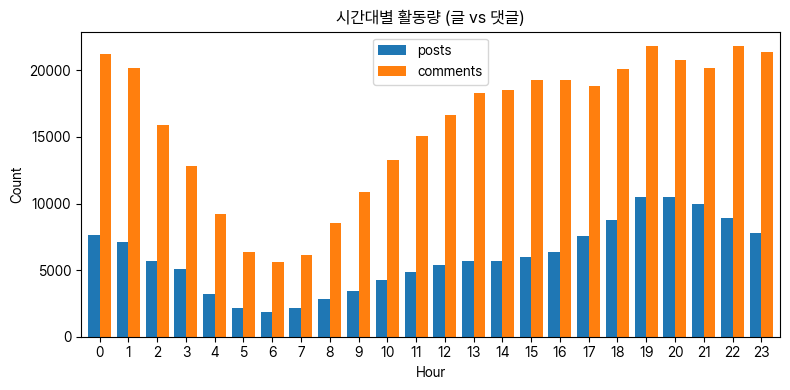

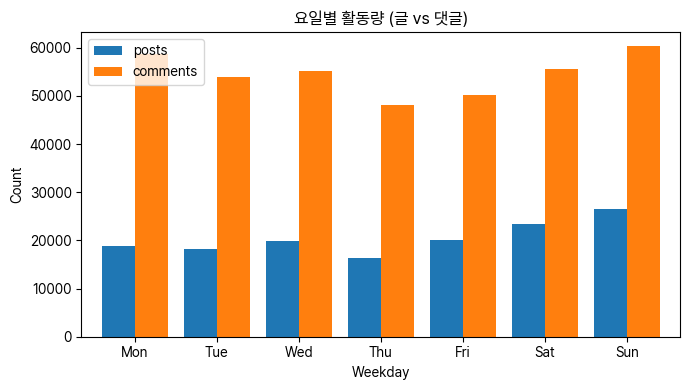

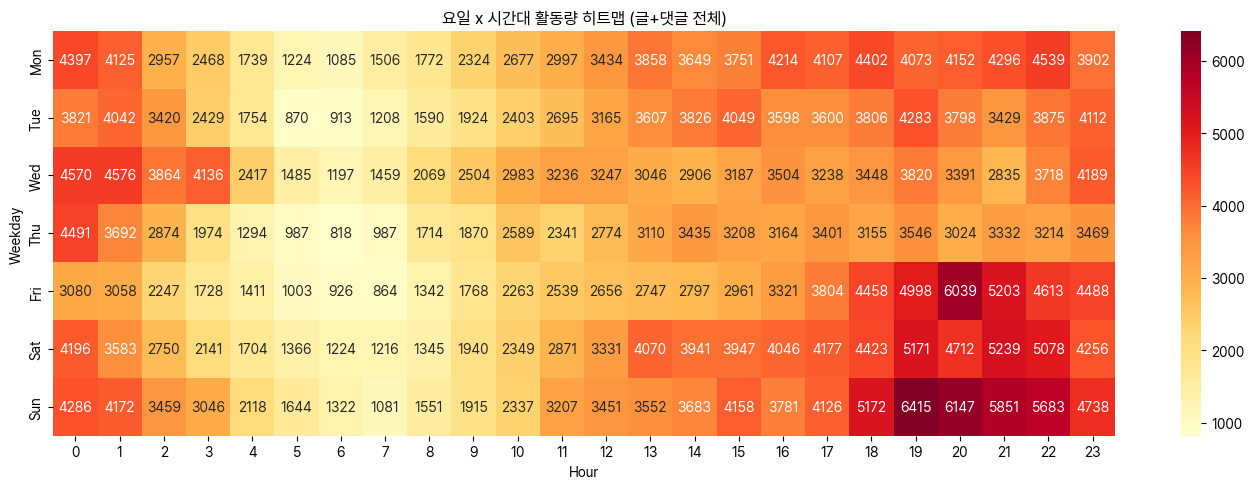

In [41]:
font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"  # 폰트 파일 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 시간대별 활동량
plt.figure(figsize=(8,4))
counts_by_hour.plot(kind='bar', width=0.8, ax=plt.gca())
plt.title('시간대별 활동량 (글 vs 댓글)')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 요일별 활동량
plt.figure(figsize=(7,4))
counts_by_weekday.plot(kind='bar', width=0.8, ax=plt.gca())
plt.title('요일별 활동량 (글 vs 댓글)')
plt.xlabel('Weekday')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 히트맵 시각화
plt.figure(figsize=(14,5))
sns.heatmap(heatmap_data, cmap='YlOrRd', annot=True, fmt='d')
plt.title('요일 x 시간대 활동량 히트맵 (글+댓글 전체)')
plt.xlabel('Hour')
plt.ylabel('Weekday')
plt.tight_layout()
plt.show()

### 분석

1. **시간대별 활동 패턴**

- 심야~새벽(00~03시)
    - 댓글 활동량이 높은 시간대 중 하나
    - 글 작성량도 비교적 높은 편
    - 하루를 마무리하고 게임을 즐긴 후 커뮤니티 활동을 했을 가능성이 높음

- 새벽~아침(04~08시)
    - 글/댓글 모두 최저치

- 오전~점심(09~12시)
    - 댓글이 글 대비 약 2~3배 수준
    - 글은 서서히 증가함 → 출근/등교 후 커뮤니티 접속 시작 시점

- 오후(13~17시)
    - 댓글량은 안정적으로 높음
    - 글도 완만하게 높아지지만 댓글이 주도
    - 일과 중 간헐적 접속하여 새벽에 올린 글에 댓글을 달거나 할 확률이 높음.
    - 모바일 댓글 참여가 많을 가능성

- 저녁(18~22시)
    - 글/댓글 모두 최다 활동 시간대
    - 19~21시 글 작성량이 최정점
    - 댓글도 같이 올라가긴 하지만 이 시간대에서 격차가 다소 줄어듦.
- 심야(23시)
    - 댓글량이 다시 급증
    - 글도 평균 이상 수준

2. **요일별 활동 패턴**

- 월요일
    - 댓글이 6만 건에 가까울 정도로 높고 글도 약 19000건 수준
    - 주말 동안 생긴 이슈를 월요일에 소비/반응하는 경향으로 해석됨.

- 화/수요일
    - 전체적으로 월요일과 비슷하며 소폭 증가함

- 목요일
    - 댓글/ 게시글 모두 주중 최저치
    - 이벤트나 콘텐츠 투입 효과가 떨어질 가능성이 있음

- 금요일
    - 댓글이 다시 증가세로 돌아서고 글도 목요일 대비 많이 상승함
    - 주말 전야 분위기로 커뮤니티 이용이 늘어나는 패턴

- 토요일
    - 글과 댓글 모두 주중보다 확실히 높음
    - 특히 글의 증가량이 눈에 띔

- 일요일
    - 댓글·글 모두 주중 최고치.
    - 주말 마무리 전 활동이 집중되는 날이며, 댓글은 6만 건을 넘어섬
    - 금, 토, 일은 오버워치 리그가 운영되는 날이며, 그로 인해서 글과 댓글수 증가량이 더욱 높았을 가능성이 있음.

3. **요일x시간대 활동 패턴**

- 절대 피크 구간
    - 토요일 20~22시, 일요일 20~21시가 가장 진하게 나타남
    - 주말 저녁 타임은 글/댓글 모두 집중되는 구간 → 이벤트, 공지, 마케팅 집중 배치 최적

- 주중
    - 월~목은 전반적으로 0~2시와 18~22시에 활동량이 높음
    - 목요일은 오전/오후 전반적으로 활동량이 가장 낮음

- 금요일
    - 금요일은 낮 동안 활동이 적다가 19시 이후 급증해 20~21시에 6천 건 이상

### 마케팅 인사이트

1. 콘텐츠 발행·이벤트 진행 최적 타이밍
- 저녁 골든타임(18~22시)
    - 모든 요일에서 활동량이 높고 주말에는 절대 피크를 형성함
    - 신규 콘텐츠 공개, 핵심 이벤트 시작, 대규모 공지 발행은 이 시간대에 집중하는 것이 최적


2. 요일별 운영 전략
- 월요일
    - 주말에 발생한 이슈를 월요일에 소비하는 경향
        - 금토일 진행한 경기 총 리뷰, 하이라이트 영상 배포에 효과적

- 화/수요일
    - 전반적으로 안정적인 활동량
        - 장기 캠페인 진행 시 중간 점검, 참여 독려 알림,팝업을 발송하기 적합함

- 목요일
    - 전반적으로 저활성
        - 상대적으로 활동 비율이 적은 목요일에 실시간 참여형 이벤트(투표, 퀴즈, 인증샷 등)나 대규모 이벤트 예고 등 가벼운 콘텐츠 배치

- 금~일요일
    - 게임 외적으로도 오버워치 리그 관련 반응 유도, 응원 이벤트, 경기 예측 콘텐츠

## 3. 컨텐츠 성격 분석

In [42]:
df.head()

,href,post_type,post_user,date,view_cnt,prefer,nonprefer,review_cnt,full_text,is_comment,date_dt,hour,weekday,weekday_name
0,/mgallery/board/view/?id=overwatch2&no=555815&...,[일반],ㅇㅇ(115.138),2025.06.08 11:50:17,144,0,0,10,본인 근데 진짜 왜 플딱인지 모르겟음 일단 힐러라 그런거 같긴함친구 다이아 계정으로...,False,2025-06-08 11:50:17,11,6,Sun
1,/mgallery/board/view/?id=overwatch2&no=625043&...,[일반],ㅇㅇ(115.140),2025.07.03 00:41:25,140,0,0,2,나도 고소할게 너희들 내가 고소하기전에 어거 버거를 내놔 오늘 저녁 못 먹엄ㅅ다 ...,False,2025-07-03 00:41:25,0,3,Thu
2,/mgallery/board/view/?id=overwatch2&no=606143&...,[일반],ㅇㅇ(175.208),2025.06.25 08:02:46,46,0,0,0,아니시발 8시밖에 안됐는데 사당역에서 지하철 3대보냄 지하철 문열리니까 이미 사람 ...,False,2025-06-25 08:02:46,8,2,Wed
3,/mgallery/board/view/?id=overwatch2&no=574058&...,[⭐E스포츠],옵붕이(182.226),2025.06.14 21:35:59,131,0,0,0,속보)디바 신화스킨출시 10일 전 캬ㅑㅑㅑㅑ,False,2025-06-14 21:35:59,21,5,Sat
4,/mgallery/board/view/?id=overwatch2&no=581876&...,[일반],ㅇㅇ,2025.06.17 09:26:19,152,2,1,1,다이아 힐딱이 되는법.txt 1. 섭딜 요구 하면서 사이드 버리기2. 탱커한테 자원...,False,2025-06-17 09:26:19,9,1,Tue


### post_type 별 분포도 확인

[post_type별 게시글 수]
post_type
[일반]       102431
[⭐E스포츠]     30241
[🏆스타디움]      5030
[❓질문]        2354
[📸겜짤]        1494
[💎자랑]         530
[⛵옵망호]        342
[📋정보]         333
[🎯박제]         224
[🖋️창작]        201
[🧐피드백]        198
[🎉이벤트]         33
[명예의전당]         9
dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_14652\1212518654.py:36: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1212518654.py:36: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1212518654.py:36: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1212518654.py:36: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1212518654.py:36: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1212518654.py:36: UserWarning: Glyph 9973 (\N{SAILBOAT}) missing from font(s) Pretendard.
  plt.tight_layo

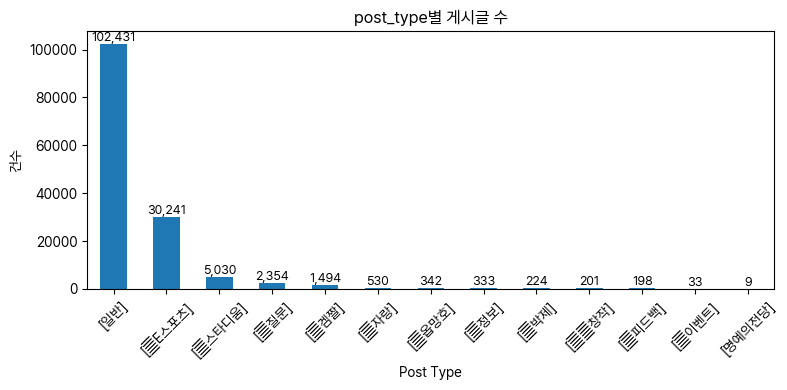

In [43]:
# 폰트 설정
font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"  # 폰트 파일 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 댓글 여부 플래그
df['is_comment'] = df['post_type'].eq('[댓글]')

# 게시글만 추출 후 post_type별 개수
post_type_counts = (df.loc[~df['is_comment']]
                    .groupby('post_type')
                    .size()
                    .sort_values(ascending=False))

# 표 출력
print("[post_type별 게시글 수]")
print(post_type_counts)

# 시각화 + 바 위에 숫자 표시
plt.figure(figsize=(8,4))
ax = post_type_counts.plot(kind='bar')

# 막대 위에 값 표시
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2,   # x 좌표 (막대 중앙)
            height,                        # y 좌표 (막대 끝)
            f'{int(height):,}',            # 표시할 텍스트 (천 단위 콤마)
            ha='center', va='bottom', fontsize=9)

plt.title('post_type별 게시글 수')
plt.xlabel('Post Type')
plt.ylabel('건수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 요일 x post_type 분포

C:\Users\user\AppData\Local\Temp\ipykernel_14652\1839083598.py:40: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1839083598.py:40: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1839083598.py:40: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1839083598.py:40: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1839083598.py:40: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) Pretendard.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_14652\1839083598.py:40: UserWarning: Glyph 9973 (\N{SAILBOAT}) missing from font(s) Pretendard.
  plt.tight_layo

<Figure size 1000x600 with 0 Axes>

C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Pretendard.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Pretendard.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) Pretendard.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) Pretendard.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128142 (\N{GEM STO

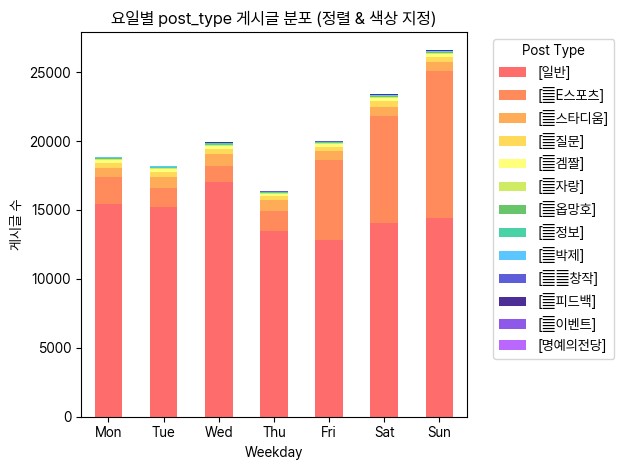

In [44]:
# 댓글 제외 & 요일별 post_type 집계
weekday_posttype_counts = (
    df.loc[~df['is_comment']]
      .groupby(['weekday_name', 'post_type'])
      .size()
      .unstack(fill_value=0)
      .reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
)

# 전체 합계 기준으로 컬럼 정렬 (많은 순 → 적은 순)
col_order = weekday_posttype_counts.sum(axis=0).sort_values(ascending=False).index.tolist()
weekday_posttype_counts = weekday_posttype_counts[col_order]

# 색상 팔레트 (빨→주→노→초→파 계열, 필요 시 컬럼 개수 맞춰 반복)
colors = [
    "#FF6C6C",  # 빨강
    "#FF8A5C",  # 적주(레드-오렌지)
    "#FFAC59",  # 주황
    "#FFD95A",  # 황(옐로-오렌지)
    "#FFFF7B",  # 노랑
    "#CFEA63",  # 연두
    "#69C569",  # 초록
    "#49D2A5",  # 청록
    "#5BC6FF",  # 하늘
    "#5D5DDA",  # 파랑
    "#4B2F97",  # 남색
    "#8E58E8",  # 남보 사이
    "#BA67FF",  # 보라
]

# 시각화
plt.figure(figsize=(10,6))
weekday_posttype_counts.plot(kind='bar', stacked=True, color=colors[:len(weekday_posttype_counts.columns)])

plt.title('요일별 post_type 게시글 분포 (정렬 & 색상 지정)')
plt.xlabel('Weekday')
plt.ylabel('게시글 수')
plt.xticks(rotation=0)
plt.legend(title='Post Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 분석

1. [일반]의 우위
- 모든 요일에서 [일반] 카테고리가 압도적으로 많음
- 주중 중반에 활발한 자유 대화·잡담 활동이 집중됨(수요일)
- 수요일 뒤로 월요일, 화요일이 그 뒤를 잇고 주말은 주중보다는 글의 비중이 떨어지는 편임 → 주말은 다른 카테고리 활동이 상대적으로 늘어나는 경향이 있음

2. 전체 게시글 기준 활동량
- 일요일이 가장 높음과 동시에 다양한 말머리 활동이 일어남
- 일요일 > 토요일 > 금요일 순으로 높음
- 수요일은 금요일과 비슷하지만, [일반] 카테고리의 글 절대량이 최다
    - 오버워치2의 주간 챌린지는 수요일 새벽시간에 리셋되기 때문에 유저들에게는 중요한 날임
    - 대규모 시즌 업데이트나 특별한 이벤트 등 모두 수요일에 시작되는 경우가 많음

3. 주말 패턴
- 토/일 은 [E스포츠], [스타디움], [옵망호] 등의 비중이 크게 상승함
    - [스타디움] 은 스타디움 모드용 말머리이고, [옵망호] 는 같이 할 파티원을 모집하는 말머리임
- 경기/게임 파티 모집 등 테마형 활동이 많음

4. 평일 패턴
- 월,화,수,목 은 다른 카테고리에 비해 [일반] 비중이 매우 높음
    - 주말 대비 특정 이벤트나 경기 영향이 적고, 자유 게시글 중심이라는 것

### 조회수 vs 반응(호감·비호감) 상관관계 분석

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525638 entries, 0 to 525637
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   href          525638 non-null  object        
 1   post_type     525638 non-null  object        
 2   post_user     525638 non-null  object        
 3   date          525638 non-null  object        
 4   view_cnt      525638 non-null  int64         
 5   prefer        525638 non-null  int64         
 6   nonprefer     525638 non-null  int64         
 7   review_cnt    525638 non-null  int64         
 8   full_text     525636 non-null  object        
 9   is_comment    525638 non-null  bool          
 10  date_dt       525638 non-null  datetime64[ns]
 11  hour          525638 non-null  int32         
 12  weekday       525638 non-null  int32         
 13  weekday_name  525638 non-null  object        
dtypes: bool(1), datetime64[ns](1), int32(2), int64(4), object(6)
memory 

           view_cnt    prefer  nonprefer
view_cnt   1.000000  0.655552   0.276195
prefer     0.655552  1.000000   0.373950
nonprefer  0.276195  0.373950   1.000000


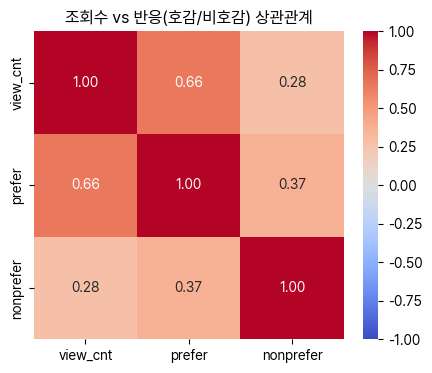

In [46]:
# 분석 대상 컬럼
cols = ['view_cnt', 'prefer', 'nonprefer']

# 상관계수 계산
corr = df[cols].corr(method='pearson')
print(corr)

# 히트맵 시각화
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("조회수 vs 반응(호감/비호감) 상관관계")
plt.show()

1. 조회수 ↔ 호감(prefer)
- 상관계수 0.66 (중~높은 양의 상관관계)
- 조회수가 높은 글일수록 호감 수가 비례적으로 많이 달리는 경향이 뚜렷함
- 즉, 많이 읽힌 글이 긍정 반응을 받을 확률이 높고 인기글로 올라갈 가능성이 큼

2. 조회수 ↔ 비호감(nonprefer)
- 상관계수 0.28 (낮은 양의 상관관계)
- 조회수가 많아도 비호감 수는 크게 늘지 않음.
- 호감의 갯수가 많으면 인기글로 올라가니 호감버튼은 잘 누르지만 굳이 비호감 버튼을 누르지 않을 가능성이 큼

3. 호감(prefer) ↔ 비호감(nonprefer)
- 상관계수 0.37 (낮은 양의 상관관계)
- 호감과 비호감이 동시에 늘어나는 경우가 일부 있음 → 논쟁성 글이나 화제성 이슈 글에서 양쪽 반응이 모두 많아지는 패턴.
- 하지만 상관계수가 높지 않으므로, 대다수 글은 호감과 비호감이 함께 늘지는 않음.

### 댓글수 vs 반응(호감·비호감) 상관관계 분석

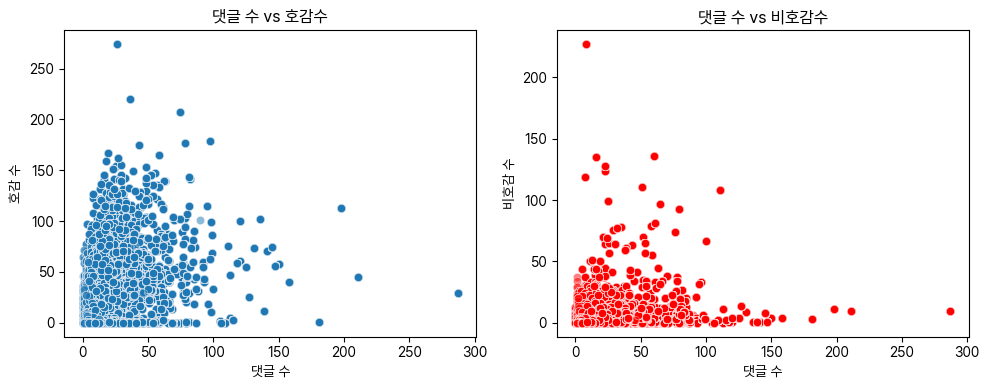

In [47]:
# 댓글 수와 prefer/nonprefer 관계 산점도
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.scatterplot(x='review_cnt', y='prefer', data=df, alpha=0.5)
plt.title("댓글 수 vs 호감수")
plt.xlabel("댓글 수")
plt.ylabel("호감 수")

plt.subplot(1,2,2)
sns.scatterplot(x='review_cnt', y='nonprefer', data=df, alpha=0.5, color='red')
plt.title("댓글 수 vs 비호감수")
plt.xlabel("댓글 수")
plt.ylabel("비호감 수")

plt.tight_layout()
plt.show()

1. 댓글 수 ↔ 호감 수
- 전반적으로 댓글이 많은 글일수록 호감 수가 높아지는 경향이 있음
- 다만 분산이 크고, 일부 글은 댓글이 많아도 호감이 낮은 경우가 존재
- 댓글 수가 50~100개 사이일 때도 호감 0~200까지 폭넓게 분포 → 글 성격에 따라 반응 편차 큼

2. 댓글 수 ↔ 비호감 수
- 댓글이 많다고 비호감이 반드시 높아지는 것은 아님
- 대부분의 글은 비호감 수가 50 이하에 머물며, 극단적으로 높은 경우(100 이상)는 매우 드물다
- 일부 글은 댓글 수가 많지 않아도 비호감이 높은 경우가 있음 → 특정 주제나 발언이 직접적인 반감을 유발한 사례일 것임

## 4. 텍스트 분석

### 전처리

In [48]:
# 데이터 필터링

df1 = df[(df['post_type'].isin(['[일반]', '[자랑]', '[댓글]'])) & df['full_text'].notna()]

In [49]:
word_df = df1[['full_text']].copy()

In [50]:
word_df

,full_text
0,본인 근데 진짜 왜 플딱인지 모르겟음 일단 힐러라 그런거 같긴함친구 다이아 계정으로...
1,나도 고소할게 너희들 내가 고소하기전에 어거 버거를 내놔 오늘 저녁 못 먹엄ㅅ다 ...
2,아니시발 8시밖에 안됐는데 사당역에서 지하철 3대보냄 지하철 문열리니까 이미 사람 ...
4,다이아 힐딱이 되는법.txt 1. 섭딜 요구 하면서 사이드 버리기2. 탱커한테 자원...
6,머리 ㅈㄴ 뜨거운 주딱은 개추 ㅇㅇ - dc official App
...,...
525633,새대가리 못하는거 알긴해서 딜할때는 남탓 안함
525634,서브딜러가 영향력 커서 올리기 쉬움
525635,"캐서디로는 자유 경쟁전 골드에서도 털리는데, 벤쳐로 다이아임"
525636,새대가리 겐파솔 세개만 파볼생각임


In [51]:
word_df = word_df.copy().reset_index(drop=True)

# 한국어 정제(기본 노이즈 제거)

URL_RE      = re.compile(r"(https?://\S+|www\.\S+)")
HTML_TAG_RE = re.compile(r"<[^>]+>")
WS_RE       = re.compile(r"\s+")

def clean_korean_text(s: str) -> str:
    if s is None:
        return ""
    s = str(s)
    s = URL_RE.sub(" ", s)
    s = HTML_TAG_RE.sub(" ", s)
    # 과도한 반복 축소
    s = re.sub(r"(ㅋ){2,}", "ㅋㅋ", s)
    s = re.sub(r"(ㅎ){2,}", "ㅎㅎ", s)
    s = re.sub(r"[ㅠㅜ]{2,}", "ㅠㅠ", s)
    s = re.sub(r"(.)\1{2,}", r"\1\1", s)        # 문자 3연속 → 2개
    # 한글/영문/숫자/기본 구두점만
    s = re.sub(r"[^가-힣a-zA-Z0-9\s\.\,\!\?\~\'\"\-\(\)…·]", " ", s)
    s = re.sub(r"\.{3,}", "...", s)
    s = re.sub(r"\!{3,}", "!!", s)
    s = re.sub(r"\?{3,}", "??", s)
    s = WS_RE.sub(" ", s).strip()
    return s

cleaned = []
for i in range(len(word_df)):
    cleaned.append(clean_korean_text(word_df.loc[i, "full_text"]))
word_df["full_text"] = cleaned

In [52]:
word_df = word_df[word_df["full_text"].str.len() > 10].reset_index(drop=True)

In [53]:
word_df = word_df[~word_df["full_text"].str.contains('http|마우스|지하철|디시콘 보기|이미지 순서 ON|군대|예비군|이기|김대중|애미', case=False, na=False)]

In [54]:
word_df["full_text"] = (word_df["full_text"].fillna("").str.replace(r' - dc App| - dc official App|dc App|갤러리잘안해요|Prelude51|옵붕이11590|Buonaparte|루리웹0|둥글레차|DVNO|글쓴 옵붕이11645|HIDCtrl|Hori21|싸개|새대가리|dc App|쪼낙|둘기마왕|류제홍|HIDCtrl|', '', case=False, regex=True))

In [55]:
word_df = word_df.reset_index(drop=True)

In [56]:
# train/test로 나누기
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(word_df, train_size=1000, shuffle=True, random_state=38)

print(len(train_df), len(test_df))

1000 388040


In [57]:
train_df.to_csv("22-2. train_커뮤니티.csv", index=False, encoding="utf-8")
test_df.to_csv("22-2. test_커뮤니티.csv", index=False, encoding="utf-8")

In [58]:
# 긍정이면 1, 부정이면 0으로 약라벨 붙이기

def pos_neg_from_result(res):
    # res가 [ {'label':'0','score':..}, {'label':'1','score':..} ] 또는 단일 dict일 수도 있음
    if isinstance(res, dict) and 'label' in res:  # 단일 결과(최댓값만 반환한 경우)
        lab, sc = res['label'], float(res['score'])
        if lab in ('1','POS','positive','LABEL_1'):
            return sc, 1.0 - sc
        else:
            return 1.0 - sc, sc
    # 다중 점수 반환(return_all_scores=True)
    m = {x['label']: float(x['score']) for x in res}
    pos = m.get('1') or m.get('POS') or m.get('positive') or m.get('LABEL_1')
    neg = m.get('0') or m.get('NEG') or m.get('negative') or m.get('LABEL_0')
    return pos, neg

In [59]:
# BERT 모델과 토크나이저 불러오기
model_name = "beomi/kcbert-base"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# 파이프라인 생성
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

# 텍스트 리스트
texts = train_df['full_text'].fillna('').astype(str).tolist()
N = len(texts)

CHUNK = 1000
BATCH = 32
labels = []

t0 = time.time()
for start in range(0, N, CHUNK):
    end = min(start + CHUNK, N)
    sub = texts[start:end]

    preds = pipeline(sub, batch_size=BATCH, truncation=True)

    for r in preds:
        p, n = pos_neg_from_result(r)
        label = 1 if p >= n else 0
        labels.append(label)

    done = end
    elapsed = time.time() - t0
    speed = done / elapsed if elapsed > 0 else 0.0
    remaining_sec = (N - done) / speed if speed > 0 else 0.0
    print(
        f"{done:,}/{N:,} ({done/N:.2%}) | "
        f"elapsed {elapsed/60:.1f} min | "
        f"speed {speed:.1f}/s | "
        f"ETA {remaining_sec/60:.1f} min",
        flush=True
    )

# 결과 저장
train_df = train_df.copy()
train_df['label'] = np.array(labels, dtype='int8')

print(train_df.head())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cuda:0
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


1,000/1,000 (100.00%) | elapsed 0.0 min | speed 391.0/s | ETA 0.0 min
                                                full_text  label
737     너네 주사율 높은거 체감 됨? 원래 TN패널 FHD 240 쓰다가 OLED QHD ...      0
384892  이응 준빈이 리그때부터도 볼을 꺼내긴했으나 고트라고 할 정도는 아직은 시기상조 아닐...      0
135463                       니도 쌩배면 니가캐리해야지 애초에 뉴비큐잡아주는덴데      0
116595           심심해서 한번 무빙 거의 안치고 제자리 에임해봤는데도 게임 굴러가더라 씹      0
119446                                       남자 대가리 존나 크네      1


In [ ]:
train_df.to_csv("22-2. train_커뮤니티.csv", index=False, encoding="utf-8")

In [ ]:
# train파일 약레벨 만들어진 것 수작업으로 조정
pn = pd.read_csv("22-3. train_커뮤니티_수작업.csv", encoding='cp949')

In [3]:
pn

,full_text,label
0,모든 맵 힐팩 위치 정리된거 없음,0
1,보고 배우라고 말씀드려,0
2,겁나 강한데 뭔소리여,0
3,자경이 쉬운게 날먹판이 은근 많이나옴 역고에비해그래서 찍기 쉽다고 느껴짐일단 상대 ...,1
4,진짜 쳐못한거 아니면 상대가 욕한다는건 극찬이긴해,1
...,...,...
622,호그할때 딜러들 뭐하면 좋아함 주딱아,1
623,그럴땐 나도 안하긴해 근데 입구막 당했다고 겜 대충하는 새끼들이나 픽창부터 지랄하는...,0
624,볼은 딜힐 문제지 탱이 볼 카운터 칠게 뭐가 있음 그리고 오히려 따지자면 볼할때 오...,0
625,원탱이라 부담감 됨 딜힐픽에 영향많이받아서 좆노잼임,0


In [4]:
test_df = pd.read_csv('22-2. test_커뮤니티.csv', encoding="utf-8")

In [5]:
import re
from konlpy.tag import Okt

okt = Okt()

stopwords = set([
    '의','가','이','은','들','는','좀','잘','걍','과','를','으로','자','에','와','한',
    '하다','는','가','이다','을','를','이','다','그','한','것','등','그리고','나',
    '아니','있다','없다','같다','때문에','고'
])

_url_re = re.compile(r'https?://\S+|www\.\S+')
_mention_re = re.compile(r'(@|#)\S+')
_num_re = re.compile(r'\d+')
_space_re = re.compile(r'\s+')

def normalize(text: str) -> str:
    text = text or ""
    text = _url_re.sub(' URL ', text)
    text = _mention_re.sub(' TAG ', text)
    text = _num_re.sub(' 0 ', text)
    text = _space_re.sub(' ', text).strip()
    return text

def make_okt_analyzer(stopwords=stopwords, stem=True):
    def analyzer(text):
        text = normalize(text)
        tokens = okt.morphs(text, stem=stem)
        return [t for t in tokens if t and t not in stopwords]
    return analyzer

analyzer = make_okt_analyzer()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

X = pn['full_text'].astype(str)
y = pn['label'].astype(int)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,5),
        max_features=300_000,
        min_df=2,
        max_df=0.95,
        sublinear_tf=True,
        dtype=np.float32,
        lowercase=False
    )),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])

# 1) 홀드아웃 검증
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
pipe.fit(X_tr, y_tr)
val_pred = pipe.predict(X_val)
print(f"[VAL] acc={accuracy_score(y_val, val_pred):.4f}")
print(f"[VAL] f1 ={f1_score(y_val, val_pred):.4f}")
print(f"[VAL] prec={precision_score(y_val, val_pred):.4f}")
print(f"[VAL] rec ={recall_score(y_val, val_pred):.4f}")

# 2) 전체 데이터로 최종 재학습
pipe.fit(X, y)

# 3) 라벨링 루프에서 사용할 벡터/모델 추출
vec = pipe.named_steps['tfidf']
clf = pipe.named_steps['clf']

[VAL] acc=0.6984
[VAL] f1 =0.6780
[VAL] prec=0.8000
[VAL] rec =0.5882


In [7]:
# Okt 토크나이저 정의
import re
from konlpy.tag import Okt

okt = Okt()

# 조사/접속사 위주 불용어(부정 신호어는 빼둠)
stopwords = set([
    '의','가','이','은','들','는','좀','잘','걍','과','를','으로','자','에','와','한',
    '것','등','그리고','그','고','하다'
])

_url = re.compile(r'https?://\S+|www\.\S+')
_mention = re.compile(r'(@|#)\S+')
_num = re.compile(r'\d+')
_space = re.compile(r'\s+')

def _norm(text: str) -> str:
    text = text or ""
    text = _url.sub(' URL ', text)
    text = _mention.sub(' TAG ', text)
    text = _num.sub(' 0 ', text)
    return _space.sub(' ', text).strip()

def okt_token(text: str):
    tokens = okt.morphs(_norm(text), stem=True)
    return [t for t in tokens if t and t not in stopwords]

# 동작 확인
print(okt_token("이 모델, 진짜 별로는 아닌데 아주 좋지도 않다."))

['모델', ',', '진짜', '별로', '아니다', '아주', '좋다', '않다', '.']


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

tfidf_vect = TfidfVectorizer(tokenizer=okt_token, ngram_range=(1,2), min_df=3, max_df=0.9)
                                    # 위에서 만든 함수
tfidf_vect.fit(pn['full_text'])
tfidf_matrix_train = tfidf_vect.transform(pn['full_text'])

c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행.
lg_clf = LogisticRegression(random_state=0, solver='liblinear')

# Parameter C 최적화를 위해 GridSearchCV 를 이용.
# C는 규제(Regularization): 규제는 모델의 복잡성을 줄여 과적합(overfitting)을 방지하는 방법입니다.
params = { 'C': [1 ,3.5, 4.5, 5.5, 10 ] }
grid_cv = GridSearchCV(lg_clf , param_grid=params , cv=3 ,scoring='accuracy', verbose=1 )
                    # lg_clf : 학습할 기본 모델(여기선 로지스틱)
                              # param_grid : 실험해볼 하이퍼파라미터 조합 딕셔너리
                                                   # cv: 교차검증 횟수
                                                        # 모델 성능 측정 기준은 정확도(accuracy)
                                                                            # verbose : 실행 상황을 출력해서 진행상황 확인 가능 (0이면 조용함)

#어차피 학습과 테스트 데이터가 나누어져 있기 때문에 따로 스플릿 할 필요는 없습니다.
grid_cv.fit(tfidf_matrix_train , pn['label'] ) #학습
print(grid_cv.best_params_ , round(grid_cv.best_score_,4)) # 최적의 파라미터 도출

Fitting 3 folds for each of 5 candidates, totalling 15 fits
{'C': 4.5} 0.6172


In [ ]:
import pandas as pd, math

TEST_PATH = '22-2. test_커뮤니티.csv'
SHARDS    = 8

df = pd.read_csv(TEST_PATH)
df = df.reset_index(drop=True)
df['idx'] = df.index
cols = ['idx'] + [c for c in df.columns if c != 'idx']
df = df[cols]

rows = len(df)
per  = math.ceil(rows / SHARDS)
for k in range(SHARDS):
    s, e = k*per, min((k+1)*per, rows)
    if s >= e: break
    df.iloc[s:e].to_csv(f"test_part_{k:02d}.csv", index=False, encoding='utf-8-sig')
    print(f"wrote test_part_{k:02d}.csv: {e-s:,} rows")

wrote test_part_00.csv: 48,505 rows
wrote test_part_01.csv: 48,505 rows
wrote test_part_02.csv: 48,505 rows
wrote test_part_03.csv: 48,505 rows
wrote test_part_04.csv: 48,505 rows
wrote test_part_05.csv: 48,505 rows
wrote test_part_06.csv: 48,505 rows
wrote test_part_07.csv: 48,505 rows


In [11]:
from konlpy import jvm
try:
    jvm.init_jvm(max_heap_size='8g')
except:
    pass

In [ ]:
import os, gc, numpy as np, pandas as pd

BATCH = 1000
MICRO = 32   # 필요시 16/8까지 낮추기

def label_one_part(part_path):
    part = pd.read_csv(part_path)
    assert {'idx','full_text'} <= set(part.columns)

    part_partial = part_path.replace(".csv", "_labels_partial.csv")
    part_final   = part_path.replace(".csv", "_with_labels.csv")

    processed = set()
    if os.path.exists(part_partial):
        prev = pd.read_csv(part_partial, usecols=['idx','label']).drop_duplicates('idx', keep='last')
        processed = set(prev['idx'])
        print(f"[{part_path}] resume: {len(processed):,} rows already labeled")

    buffer = []
    def flush():
        nonlocal buffer
        if not buffer: return
        dfb = pd.DataFrame(buffer, columns=['idx','label'])
        header = not os.path.exists(part_partial)
        dfb.to_csv(part_partial, mode='a', header=header, index=False, encoding='utf-8-sig')
        buffer = []
        print(f"[{part_path}] checkpoint: +{len(dfb):,}")

    N = len(part)
    for s in range(0, N, BATCH):
        e = min(s+BATCH, N)
        block = part.iloc[s:e]
        mask = ~block['idx'].isin(processed)
        if not mask.any():
            print(f"[{part_path}] {e}/{N} skipped")
            continue

        texts = block.loc[mask, 'full_text'].astype(str).tolist()
        idxs  = block.loc[mask, 'idx'].tolist()

        for t0 in range(0, len(texts), MICRO):
            sub_texts = texts[t0:t0+MICRO]
            sub_idx   = idxs[t0:t0+MICRO]
            Xb   = vec.transform(sub_texts)       # <- 여기서 JVM 메모리 사용
            pred = clf.predict(Xb).astype('int8')
            buffer.extend(zip(sub_idx, pred))
            del Xb, pred
            gc.collect()

        flush()
        print(f"[{part_path}] {e}/{N} processed")

    # 파트 최종 병합
    try:
        lbl = pd.read_csv(part_partial).drop_duplicates('idx', keep='last').set_index('idx').sort_index()
        out = part.copy()
        out = out.set_index('idx').sort_index()
        out['label'] = np.nan
        common = out.index.intersection(lbl.index)
        out.loc[common, 'label'] = lbl.loc[common, 'label'].astype('int8')
        out.reset_index().to_csv(part_final, index=False, encoding='utf-8-sig')
        print(f"[{part_path}] final: {part_final} (labeled {len(common):,}/{len(part):,})")
    except Exception as e:
        print(f"[{part_path}] final build failed:", e)

# 실행: 파트들을 순차 처리
for k in range(SHARDS):
    label_one_part(f"test_part_{k:02d}.csv")

[test_part_00.csv] resume: 48,505 rows already labeled
[test_part_00.csv] 1000/48505 skipped
[test_part_00.csv] 2000/48505 skipped
[test_part_00.csv] 3000/48505 skipped
[test_part_00.csv] 4000/48505 skipped
[test_part_00.csv] 5000/48505 skipped
[test_part_00.csv] 6000/48505 skipped
[test_part_00.csv] 7000/48505 skipped
[test_part_00.csv] 8000/48505 skipped
[test_part_00.csv] 9000/48505 skipped
[test_part_00.csv] 10000/48505 skipped
[test_part_00.csv] 11000/48505 skipped
[test_part_00.csv] 12000/48505 skipped
[test_part_00.csv] 13000/48505 skipped
[test_part_00.csv] 14000/48505 skipped
[test_part_00.csv] 15000/48505 skipped
[test_part_00.csv] 16000/48505 skipped
[test_part_00.csv] 17000/48505 skipped
[test_part_00.csv] 18000/48505 skipped
[test_part_00.csv] 19000/48505 skipped
[test_part_00.csv] 20000/48505 skipped
[test_part_00.csv] 21000/48505 skipped
[test_part_00.csv] 22000/48505 skipped
[test_part_00.csv] 23000/48505 skipped
[test_part_00.csv] 24000/48505 skipped
[test_part_00.csv]

In [13]:
SHARDS = 8
parts = []

for k in range(SHARDS):
    fname = f"test_part_{k:02d}_with_labels.csv"
    df_part = pd.read_csv(fname)
    parts.append(df_part)

# 조각 합치기
df_all = pd.concat(parts, ignore_index=True)

# idx 기준 정렬 (혹시 순서가 섞였을 경우 대비)
df_all = df_all.sort_values('idx').reset_index(drop=True)

# 저장
df_all.to_csv("22-3. test_all_labeled.csv", index=False, encoding='utf-8-sig')
print(f"합친 데이터 저장 완료: {len(df_all):,} rows")

합친 데이터 저장 완료: 388,040 rows


In [15]:
# 파일 불러오기
train_df = pd.read_csv("22-3. train_커뮤니티_수작업.csv", encoding="cp949")
test_df = pd.read_csv("22-3. test_all_labeled.csv", encoding="utf-8")

# 컬럼 순서 맞추기 (train 컬럼 순서 기준)
test_df = test_df[train_df.columns]

# 행 방향으로 합치기
full_df = pd.concat([train_df, test_df], ignore_index=True)

# 저장
full_df.to_csv("22-4. all_labeled_커뮤니티.csv", index=False, encoding="utf-8-sig")
print(f"합친 데이터 저장 완료: {len(full_df):,} rows")

합친 데이터 저장 완료: 388,667 rows


### 긍/부정 키워드 워드클라우드

라벨 NaN 개수: 0
label
1    212219
0    176407
Name: count, dtype: int64


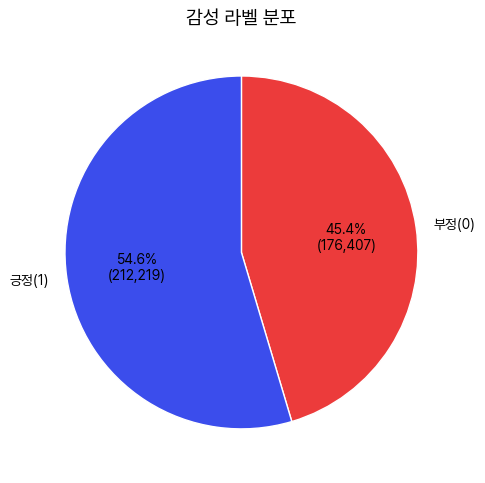

In [37]:
# 폰트 설정
font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"  # 폰트 파일 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

df = pd.read_csv('22-4. all_labeled_커뮤니티.csv', encoding='utf-8-sig')

# df: 라벨 포함된 데이터프레임 (train_df+test_df 병합 or 파일 로드 결과)
df = df.dropna(subset=['full_text']).copy()

# 1) label을 숫자로 강제 변환(문자 '0','1' 등 포함) → 변환 실패는 NaN으로
df['label'] = pd.to_numeric(df['label'], errors='coerce')

# 2) 0/1만 남기고 나머지(NaN 포함) 제거
print("라벨 NaN 개수:", df['label'].isna().sum())
df = df[df['label'].isin([0, 1])].copy()

# 3) 이제 안전하게 정수형으로
df['label'] = df['label'].astype('int8')

print(df['label'].value_counts())


# 라벨 개수 집계
label_counts = df['label'].value_counts().sort_index()
labels = ['부정(0)', '긍정(1)']
colors=["#EC3B3B","#3B4DEC"]

# 퍼센트+건수 라벨 함수
def autopct_format(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return f"{pct:.1f}%\n({absolute:,})"

# 파이그래프
plt.figure(figsize=(5,5))
plt.pie(label_counts,
        labels=labels,
        autopct=lambda pct: autopct_format(pct, label_counts),
        colors=colors,
        startangle=90,
        counterclock=False,
        wedgeprops={'edgecolor':'white'})

plt.title('감성 라벨 분포', fontsize=14)
plt.tight_layout()
plt.show()

In [38]:
pos_texts = df.loc[df['label'] == 1, 'full_text'].astype(str).tolist()
neg_texts = df.loc[df['label'] == 0, 'full_text'].astype(str).tolist()
print(len(pos_texts), len(neg_texts))

212219 176407


In [39]:
import re
from collections import Counter

def clean_korean(s: str) -> str:
    """한글과 공백만 남기고 정리"""
    s = re.sub(r'[^가-힣\s]', ' ', str(s))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# 불용어 리스트 (카테고리별로 정리)
stopwords = {
    # 닉네임/고유명사
    '갤러리잘안해요', '새대가리', '황금경쪼드리치', '레드오션', '멘대남협회장', '주딱',
    '몽쉘스', '노굼마', '모솔아다히키존못소심찐따', '둘기마왕', '조찐타', '갈고리고정',
    '아롱', '콩먹는콩벌래', '흰수염생체핫팩에이스', '숑냥', '멘딜', '회계하라','팔기견',
    '마법소녀주노','근트릿세팅', '훈련용봇',
    
    # 웃음/유행어
    'ㅋㅋ', 'ㅎㅎ', '하셈',
    
    # 일반적인 불용어 (조사, 대명사, 부사 등)
    '거', '것', '그', '내', '이', '저', '그냥', '근데', '좀', '진짜', '개',
    '내가', '나도', '이게', '이런', '그거', '이제', '그래도', '하면', '뭐야',
    '나만', '이거', '하는', '같은', '그럼', '있는', '하고', '원래', '그래서',
    '하는데', '뭐임', '아님', '뭐가', '아닌가', '그건', '아니면', '아니라',
    '어떻게', '너무', '지금', '저거', '애초에', '계속', '그렇게', '같은데',
    '솔직히', '일단', '무조건', '같음', '같이', '그게', '해도', '거의',
    '있는데', '아니고', '보면', '나는', '뭔가', '다시', '사람', '때문에',
    '보고', '까지', '말고', '있고', '시간', '우리', '맨날', '자꾸', '갑자기',
    '애초', '이유', '생각', '그리고', '다른', '오늘', '맞음', '본인', '좋은',
    '있으면', '나오면', '사실', '이렇게', '에서', '아직', '이건', '이미', '해서',
    '했는데', '없는', '안됨', '무슨', '자체', '이건', '못하', '누가', '아직', '보통',
    '어케', '있어서', '혼자', '잘하', '오히려', '결국', '하면서', '얼마나', '하지', '빨리',
    '이해', '느낌', '상황', '우클', '차이', '대체', '옵갤', '아예', '이상', '아닌', '자기', '절대', '이해',
    '하는게', '없는데', '말이', '아닌데', '많음', '아무', '너가', '없고', '훨씬', '때문', '이번', '하다',
    '확실히', '없어서', '항상', '가끔', '아니냐', '보니까', '그러면', '좋아', '못하면', '그때', '가면', '자주', '하루종일',
    '그걸', '뭐냐', '봐도', '못해서','못함','한데','지가','인데','어차피','둘다','그나마','희상','거임','전에','않음',
    '있어', '것도','지들','영상','차라리','없이','많아서','나옴','못하고','않나','열심히','생각함','가장','가능',
    '경우','다들','하니까','모든','안함','먼저', '진지하게','시작','역시','딜힐','소리','제발','없다','감도',
    '새끼들','좋은데','여기','팀이','언제','서로',
    
    # 욕설/비하어
    '존나', '시발', '씨발', '새끼', '병신', '찐따', '멘대남', '새낀', '이새끼', '탱장연', '스토커', '좆같', '패작', '대가리','배설',
    
    # 게임 관련 일반어 (너무 흔해서 의미없는 것들)
    '게임', '오버워치', '옵치', '경쟁', '매칭', '팀', '우리팀', '상대팀',
    '승률', '랭크', '티어', '시즌', '대회', '스킨', '탱커', '힐러', '딜러', 
    '상대', '애들', '많이', '바로', '요즘', '있음', '없음', '아니', '그래', 
    '니가', '제일', '섭딜', '옵붕', '에임', '그마', '라인', '다이아', '한번', 
    '빠대', '좋음', '실력', '그런', '정도', '마스터', '플레', '프로', '골드',
    '글쓴', '여자',

    # 게임 캐릭터 (분석 목적에 따라 제거할지 결정)
    '트레', '오리사', '아나', '겐지', '키리코', '주노', '디바', '해저드', '제타', '메이', '자리', '시메', 
    '하나', '프레야', '둠피', '프로퍼', '메르시', '솜브라', '로드호그', '애쉬', '솔져', '웨스터룬드', '사운드퀘이크',
    '시그마', '솔저', '자리야', '루시우', '모이라', '윈스', '리퍼', '호그','벤처','위버','캐서디','맥크리',
    '파라', '소전', '브리', '위도우', '해먼드', '라마', '팔콘', '야타', '라쿤', '바티', '한조', '윈스턴', '마우', '에코'
}

def simple_stem(word):
    """간단한 어미 제거 (완벽하지 않지만 실용적)"""
    # 자주 나오는 어미들만 제거
    endings = ['이다', '했다', '한다', '하는', '하고', '해서', '하면', '들이', '에서', '에게', '까지', '부터', '만큼']
    
    for ending in endings:
        if word.endswith(ending) and len(word) > len(ending) + 1:
            return word[:-len(ending)]
    
    # 조사 제거
    particles = ['은', '는', '이', '가', '을', '를', '에', '와', '과', '로', '으로', '들', '도', '만']
    for particle in particles:
        if word.endswith(particle) and len(word) > len(particle) + 1:
            return word[:-len(particle)]
    
    return word

def tokenize_korean(text: str):
    """한국어 텍스트를 토큰화"""
    # 한글만 남기기
    clean_text = clean_korean(text)
    
    # 공백으로 분리
    tokens = clean_text.split()
    
    # 전처리
    processed_tokens = []
    for token in tokens:
        # 간단한 어미 제거
        stemmed = simple_stem(token)
        
        # 불용어 제거, 한글자 제거
        if stemmed not in stopwords and len(stemmed) > 1:
            processed_tokens.append(stemmed)
    
    return processed_tokens

def build_frequency(texts):
    """텍스트 리스트에서 단어 빈도 계산"""
    counter = Counter()
    for text in texts:
        tokens = tokenize_korean(text)
        counter.update(tokens)
    return counter

# 사용 예시
if __name__ == "__main__":
    # 실제 사용 (pos_texts, neg_texts가 있다고 가정)
    pos_freq = build_frequency(pos_texts)
    neg_freq = build_frequency(neg_texts)
    print("긍정 단어:", pos_freq.most_common(40))
    print("부정 단어:", neg_freq.most_common(40))

토큰화 결과: ['때문임']
긍정 단어: [('사이드', 1048), ('특전', 1032), ('스타디움', 995), ('피지컬', 985), ('방벽', 974), ('광물', 958), ('조합', 958), ('솔큐', 927), ('포지션', 919), ('너프', 830), ('체급', 827), ('탱이', 807), ('스킬', 804), ('경기', 798), ('양학', 777), ('영웅', 773), ('버프', 748), ('아군', 713), ('뒷라인', 711), ('연습', 705), ('캐릭', 701), ('유저', 648), ('유튜브', 645), ('자경', 644), ('거점', 644), ('방송', 632), ('생각보다', 619), ('추천', 617), ('메타', 608), ('메인딜', 587), ('팬텀', 585), ('헤드', 585), ('재밌음', 579), ('쉬프트', 579), ('있다', 578), ('하는거', 575), ('없으면', 574), ('스트레스', 574), ('잘하면', 573), ('은근', 572)]
부정 단어: [('팀원', 1454), ('특전', 1338), ('스타디움', 1280), ('탱이', 1230), ('문제', 1228), ('채팅', 1223), ('광물', 1216), ('사이드', 1111), ('정치', 1070), ('스킬', 1066), ('양학', 1029), ('점수', 965), ('다인큐', 952), ('뒷라인', 934), ('솔큐', 886), ('아군', 869), ('영웅', 863), ('계정', 852), ('조합', 839), ('수준', 826), ('생배', 818), ('경쟁전', 794), ('방송', 789), ('구간', 783), ('유저', 752), ('거점', 752), ('정지', 709), ('인큐', 695), ('신고', 671), ('부계', 652), ('그룹', 646), ('알아서', 6

C:\Users\user\AppData\Local\Temp\ipykernel_4632\1644816919.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")
C:\Users\user\AppData\Local\Temp\ipykernel_4632\1644816919.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds  = cm.get_cmap("Reds")


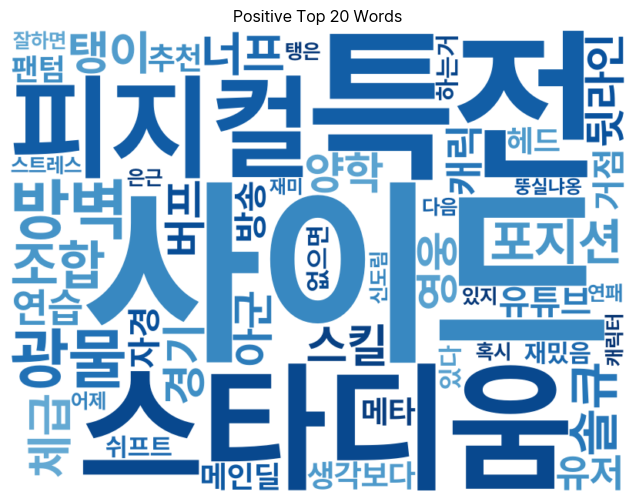

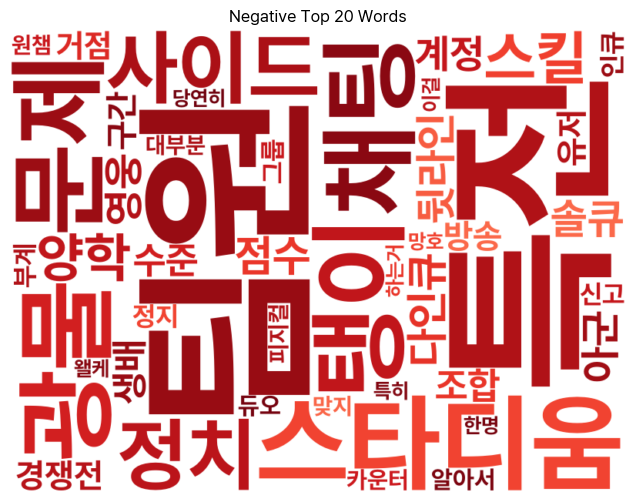

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex

# 폰트 설정
font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"  # 폰트 파일 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# "어두운 톤만" 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
blues = cm.get_cmap("Blues")
reds  = cm.get_cmap("Reds")

def dark_blues(*args, **kwargs):
    return to_hex(blues(random.uniform(0.50, 0.98)))  # 0.70~0.98 구간만 사용(더 진함)

def dark_reds(*args, **kwargs):
    return to_hex(reds(random.uniform(0.50, 0.98)))

topp = 50
topn = 45

# Positive 상위 20 단어만 추출
pos_top20 = dict(pos_freq.most_common(topp))

wc_pos = WordCloud(
    font_path=font_path,
    width=800, height=600,
    background_color="white",
    color_func=dark_blues,
    collocations=False,
).generate_from_frequencies(pos_top20)

plt.figure(figsize=(8,6))
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Top 20 Words")
plt.show()

# Negative 상위 20 단어만 추출
neg_top20 = dict(neg_freq.most_common(topn))

wc_neg = WordCloud(
    font_path=font_path,
    width=800, height=600,
    background_color="white",
    color_func=dark_reds,
    collocations=False,
).generate_from_frequencies(neg_top20)

plt.figure(figsize=(8,6))
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Top 20 Words")
plt.show()

### 분석

1. **긍정**
- 전술/전략 관련 키워드
    - 사이드, 스타디움, 포지션, 뒷라인
        - 전장 내 위치·라인 운영과 관련된 키워드
        - 특정 맵(스타디움) 중심 전략 언급 가능성 높음
    - 조합, 특전, 메타
        - 특정 팀 조합, 메타전략 같은 팀 단위 전술 키워드
        - '특전' 은 오버워치 2의 새로운 게임 모드인 '격돌'이나 '스타디움' 등 게임을 진행하면서 경험치를 얻고 레벨을 올리면
        <br>각 영웅이 가진 스킬을 강화하거나 새로운 능력을 얻을 수 있게 해주는 '영웅 특전' 을 줄인 말

- 플레이 스타일/기술 숙련도
    - 피지컬, 방벽, 광물
        - 긍정 레이블에서 '피지컬'이 언급되는 건 개인 기량을 높게 평가하는 맥락에서 썼을 가능성이 높음
    - 연습
        - 신규 영웅이 출시되었을 때, 혹은 오버워치 초보 유저가 작성한 것으로 보임

- 밸런스/패치
    - 버프, 너프
        - 긍정 레이블임에도 밸런스 패치 관련 언급이 존재
        - 긍정 레이블에서는 '필요하다'거나 '잘됐다'는 맥락일 가능성이 있음

- 외부 콘텐츠/커뮤니티
    - 방송, 유튜브, 추천
        - 외부 플랫폼과의 연계, 전략 참고 자료, 커뮤니티 추천 컨텐츠로 이어졌을 가능성이 있음

>> **특징**
<br>긍정 레이블 워드클라우드는 주로 위치선정, 라인관리, 맵 과 같은 전술적 요소와 개인의 숙련도 및 훈련의 중요성에 초점을 맞추고 있음.
<br>또한 밸런스 패치에 대한 언급이 긍정적인 맥락으로 나타나며, 이는 유저들이 패치에 만족하거나 게임의 메타 변화를 즐기는 성향이 있는 유저가 있음을 시사한다.
<br>전략 습득 및 플레이 개선을 위해 유튜브, 방송 등 외부 플랫폼을 활용하는 경향이 있으며, 특정 역할군에 대한 만족도도 긍정적 평가에 영향을 미치는 것으로 나타난다.

2. **부정**
- 문제/불만 직접 표출
    - 문제, 채팅, 계정, 정지, 신고
        - 게임 환경·운영 문제, 유저 행위(비매너/채팅), 제재 시스템과 관련
        - 부정 평가의 주요 원인이 게임 외적인 운영/유저 관리 이슈임을 시사

- 역할군/게임 시스템/경쟁 관련 불만
    - 탱, 팀원, 뒤라인, 스킬수준, 경쟁전, 카운터, 영웅, 아군, 스킬수준
        - 팀 역할군, 특히 탱커·팀원 숙련도/기여도 불만
        - 뒤라인은 포지션 운영 미숙 또는 보호 부족에 대한 불만으로 해석 가능
        - 특정 경쟁 모드나 캐릭터 간 상성 문제에서 비롯된 불만
        - 실력 편차, 밸런스 불만

- 맵/전략 용어
    - 스타디움, 사이드, 특전, 광물, 솔큐
        - 긍정과 동일하게 등장하지만 맥락이 부정적일 가능성 큼 (예: 스타디움 맵 불만, 사이드 운영 실패, 광물=저랭 유저 문제)

- 커뮤니케이션/협동 이슈
    - 채팅, 듀오, 그룹
        - 의사소통 부재, 팀플레이 부정 경험과 연결

>> **특징**
<br>부정 레이블 워드클라우드는 주로 게임 운영 및 유저 행위와 관련된 문제, 그리고 역할군 및 실력 편차에 대한 불만에서 비롯됨.
<br>긍정적인 평가와 마찬가지로 맵 및 전략 관련 용어가 자주 언급되지만 맥락은 전략 실패나 게임에 대한 불만과 관련되어 있을 수 있음.
<br>또한 소통 실패(채팅, 듀오) 문제와 게임 이용 제재(정지, 신고) 이슈도 부정적인 평가의 주요 원인으로 뚜렷하게 나타남.
<br>특정 조합 중심의 메타 고착화가 심각한 것으로 보임.

### 제안

- '스타디움', '사이드', '특전' 등 일부 키워드는 긍정·부정 모두에서 등장한다.이는 경험에 대한 질의 양극화가 존재한다는 의미이며,
<br>이는 같은 콘텐츠라도 플레이 경험·결과에 따라 평가가 갈린다는 의미이다.
- 고경험자들이 전략 성공 사례나 영웅 스킬트리 등을 공식 커뮤니티에 공유하도록 유도한다(ex. 카트라이더)
- 신규/중하위권 레벨 교육 강화 : 초보자 전용 매칭 구간을 도입하고 낙사 구간이 표시된 맵을 제공한다던가
<br>초보자가 맵과 전략에 익숙해지는 방안을 마련할 것을 제안한다.

## 5. 상호작용 분석

### 글/댓글 연결 구조 분석

In [3]:
connect_df = pd.read_csv('22-1. 감성분석용 갤러리데이터.csv', encoding='utf-8-sig')

In [4]:
connect_df.head()

,href,post_type,post_user,date,view_cnt,prefer,nonprefer,review_cnt,full_text
0,/mgallery/board/view/?id=overwatch2&no=555815&...,[일반],ㅇㅇ(115.138),2025.06.08 11:50:17,144,0,0,10,본인 근데 진짜 왜 플딱인지 모르겟음 일단 힐러라 그런거 같긴함친구 다이아 계정으로...
1,/mgallery/board/view/?id=overwatch2&no=625043&...,[일반],ㅇㅇ(115.140),2025.07.03 00:41:25,140,0,0,2,나도 고소할게 너희들 내가 고소하기전에 어거 버거를 내놔 오늘 저녁 못 먹엄ㅅ다 ...
2,/mgallery/board/view/?id=overwatch2&no=606143&...,[일반],ㅇㅇ(175.208),2025.06.25 08:02:46,46,0,0,0,아니시발 8시밖에 안됐는데 사당역에서 지하철 3대보냄 지하철 문열리니까 이미 사람 ...
3,/mgallery/board/view/?id=overwatch2&no=574058&...,[⭐E스포츠],옵붕이(182.226),2025.06.14 21:35:59,131,0,0,0,속보)디바 신화스킨출시 10일 전 캬ㅑㅑㅑㅑ
4,/mgallery/board/view/?id=overwatch2&no=581876&...,[일반],ㅇㅇ,2025.06.17 09:26:19,152,2,1,1,다이아 힐딱이 되는법.txt 1. 섭딜 요구 하면서 사이드 버리기2. 탱커한테 자원...


In [5]:
# 1) [댓글] 제외
df_posts = connect_df[connect_df['post_type'] != '[댓글]'].copy()

# 2) href 기준 중복 제거 (원글 단위 유지)
df_posts = df_posts.drop_duplicates(subset=['href'])

print(f"원본 행 수: {len(connect_df):,}")
print(f"[댓글] 제외 후: {len(connect_df[connect_df['post_type'] != '[댓글]']):,}")
print(f"중복 제거 후: {len(df_posts):,}")

원본 행 수: 525,638
[댓글] 제외 후: 143,420
중복 제거 후: 143,420


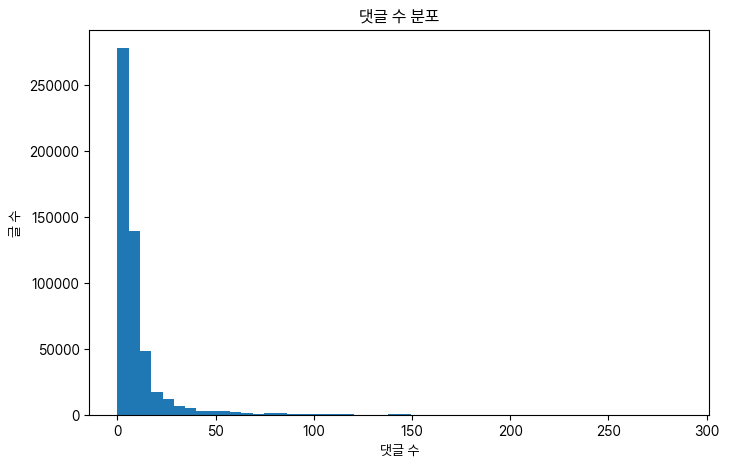

상위 1% 임계값: 78


,href,date,review_cnt,prefer,view_cnt
4391,/mgallery/board/view/?id=overwatch2&no=526324&...,2025.05.27 19:39:27,211,45,4678
5233,/mgallery/board/view/?id=overwatch2&no=677635&...,2025.07.28 18:09:40,141,71,5868
6086,/mgallery/board/view/?id=overwatch2&no=519539&...,2025.05.25 06:06:57,90,101,5800
6118,/mgallery/board/view/?id=overwatch2&no=656194&...,2025.07.18 14:42:34,92,60,7259
6379,/mgallery/board/view/?id=overwatch2&no=672259&...,2025.07.25 19:38:19,93,40,4437


In [6]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager
from difflib import get_close_matches

# 폰트 설정
font_path = "C:/Users/user/Desktop/font/Pretendard-Bold.otf"
font_name = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False

# 카피본 만들기
df = connect_df.copy()

# 1) 컬럼명 정규화
df.columns = (
    pd.Series(df.columns)
    .str.strip()
    .str.lower()
    .str.replace(r'[\s\-]+', '_', regex=True)
)

# review_cnt 후보 컬럼 찾기
pattern = re.compile(r'(review|comment).*?(cnt|count)$')
candidates = [c for c in df.columns if pattern.search(c)]

if 'review_cnt' in df.columns:
    col_reviews = 'review_cnt'
elif candidates:
    col_reviews = candidates[0]
else:
    raise KeyError("댓글 수 컬럼을 찾지 못했습니다.")

# 히스토그램
plt.figure(figsize=(8,5))
df[col_reviews].plot(kind='hist', bins=50)
plt.xlabel('댓글 수')
plt.ylabel('글 수')
plt.title('댓글 수 분포')
plt.show()

# 상위 1% 글 추출
thr = df[col_reviews].quantile(0.99)
viral = df[df[col_reviews] >= thr].copy()
print(f"상위 1% 임계값: {thr:.0f}")
display(viral[['href','date',col_reviews,'prefer','view_cnt']].head())

- 원글 기준에서는 댓글 20개 이상이면 이미 커뮤니티에서 주목받는 글
- 댓글 수를 기준으로 상위 1% 글들을 모아서 특성을 분석하면 바이럴·논쟁·이벤트 글의 유형을 파악하기 쉬울 것으로 보임.

### 댓글 상위 1% 글과 나머지 글의 조회수/좋아요 지표 비교

In [ ]:
# 상위 1% 기준치 계산
thr_review = df_posts['review_cnt'].quantile(0.99)
print(f"상위 1% 댓글 기준: {thr_review:.0f}개 이상")

# 그룹 나누기
viral = df_posts[df_posts['review_cnt'] >= thr_review]
base  = df_posts[df_posts['review_cnt'] <  thr_review]

# 요약 함수
def summary(x):
    return pd.Series({
        "mean": x.mean(),
        "median": x.median(),
        "p90": x.quantile(0.9)
    })

# 비교 테이블
meta = pd.concat({
    f"viral(review_cnt≥{thr_review:.0f})": pd.concat([
        summary(viral['prefer']).rename("prefer"),
        summary(viral['view_cnt']).rename("view_cnt")
    ], axis=1),
    "base": pd.concat([
        summary(base['prefer']).rename("prefer"),
        summary(base['view_cnt']).rename("view_cnt")
    ], axis=1)
}, axis=1)

# 출력
(meta
 .round(2)
 .style
 .format("{:.2f}")
 .highlight_max(color="#3B4DEC", axis=1)
 .highlight_min(color='#EC3B3B', axis=1)
 .set_caption(f"1% 그룹(댓글 ≥ {thr_review:.0f}) vs 일반 그룹 비교"))

상위 1% 댓글 기준: 21개 이상


1. 평균
- 댓글이 많은 글은 추천 수가 압도적으로 많음(33.47 : 0.79)
    - 단순히 댓글만 많은 게 아니고 추천 반응도 강하게 동반됨
- 조회수도 평균적으로 18배 가까이 높음(2,963 : 160)
    - 댓글이 많은 게시글은 높은 조회수와 연관됨

2. 중앙값
- 일반 글의 중앙값은 0
- 반면 1% 글의 중앙값은 추천수가 23개 이상이다
- 조회수도 중앙값 기준 약 19배 차이(1,949 : 103)

3. 상위 10% (p90)
- 1%글 중 상위 10%는 추천수 86개 이상, 조회수 6596 이상
- 일반 글의 상위 10%와 비교해도 추천은 43배, 조회수는 25배 차이

>> 해석
<br>댓글 수가 많은 글은 전체 반응 지표가 동반 상승한다 → 커뮤니티 바이럴 글 발굴 지표로 댓글 수 ≥ 21이 매우 유효하다.
<br>좋아요/조회수 상승이 동반되는 구조
<br>중앙값 차이가 매우 크다 → 평범한 글은 전혀 주목을 못 받지만 특정 조건 충족 시 반응이 폭발한다.
<br>→ "주목 조건"이 무엇인지 컨텐츠 분석 필요
<br>1% 글 키워드 분석 필요 → 왜 이런 글이 반응을 얻었는지(이벤트, 논쟁, 정보, 밈 등) 주제/키워드별로 세분화해야 함

### 1% 글에서 키워드 상위 20개 뽑기

상위 그룹 키워드 TOP 20:
선수: 129
우승: 114
스크림: 112
경기: 103
팀원: 82
조합: 76
피드백: 74
평타: 73
모습: 71
이후: 71
스테이지: 71
준우승: 67
스킬: 66
사이드: 64
옵갤컵: 61
특전: 60
제가: 56
영웅: 55
유저: 55
광물: 55


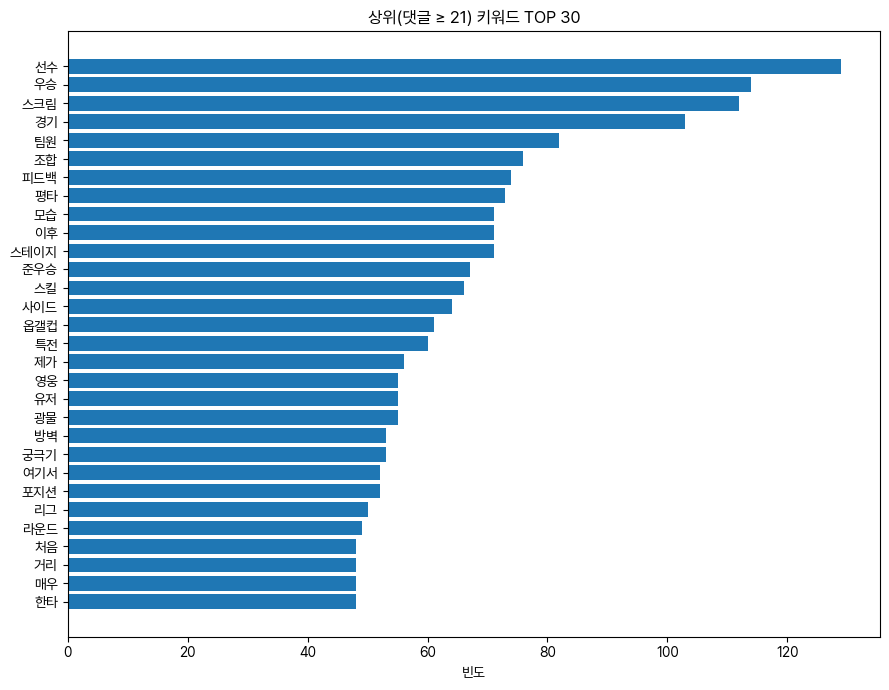

In [ ]:
import re
from collections import Counter

# 1) 댓글 ≥ 21인 그룹 필터링
viral = df_posts[df_posts['review_cnt'] >= 21].copy()

def clean_korean(s: str) -> str:
    """한글과 공백만 남기고 정리"""
    s = re.sub(r'[^가-힣\s]', ' ', str(s))
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# 불용어 리스트 (카테고리별로 정리)
stopwords = {
    # 닉네임/고유명사
    '갤러리잘안해요', '새대가리', '황금경쪼드리치', '레드오션', '멘대남협회장', '주딱',
    '몽쉘스', '노굼마', '모솔아다히키존못소심찐따', '둘기마왕', '조찐타', '갈고리고정',
    '아롱', '콩먹는콩벌래', '흰수염생체핫팩에이스', '숑냥', '멘딜', '회계하라','팔기견',
    '마법소녀주노','근트릿세팅', 
    
    # 웃음/유행어
    'ㅋㅋ', 'ㅎㅎ', '하셈',
    
    # 일반적인 불용어 (조사, 대명사, 부사 등)
    '거', '것', '그', '내', '이', '저', '그냥', '근데', '좀', '진짜', '개',
    '내가', '나도', '이게', '이런', '그거', '이제', '그래도', '하면', '뭐야',
    '나만', '이거', '하는', '같은', '그럼', '있는', '하고', '원래', '그래서',
    '하는데', '뭐임', '아님', '뭐가', '아닌가', '그건', '아니면', '아니라',
    '어떻게', '너무', '지금', '저거', '애초에', '계속', '그렇게', '같은데',
    '솔직히', '일단', '무조건', '같음', '같이', '그게', '해도', '거의',
    '있는데', '아니고', '보면', '나는', '뭔가', '다시', '사람', '때문에',
    '보고', '까지', '말고', '있고', '시간', '우리', '맨날', '자꾸', '갑자기',
    '애초', '이유', '생각', '그리고', '다른', '오늘', '맞음', '본인', '좋은',
    '있으면', '나오면', '사실', '이렇게', '에서', '아직', '이건', '이미', '해서',
    '했는데', '없는', '안됨', '무슨', '자체', '이건', '못하', '누가', '아직', '보통',
    '어케', '있어서', '혼자', '잘하', '오히려', '결국', '하면서', '얼마나', '하지', '빨리',
    '이해', '느낌', '상황', '우클', '차이', '대체', '옵갤', '아예', '이상', '아닌', '자기', '절대', '이해',
    '하는게', '없는데', '말이', '아닌데', '많음', '아무', '너가', '없고', '훨씬', '때문', '이번', '하다',
    '확실히', '없어서', '항상', '가끔', '아니냐', '보니까', '그러면', '좋아', '못하면', '그때', '가면', '자주', '하루종일',
    '그걸', '뭐냐', '봐도', '못해서','못함','한데','지가','인데','어차피','둘다','그나마','희상','거임','전에','않음',
    '있어', '것도','지들','영상','차라리','없이','많아서','나옴','못하고','않나','열심히','생각함','가장','가능',
    '경우','다들','하니까','모든','안함','먼저', '진지하게','시작','역시','딜힐','소리','제발','없다','감도',
    '새끼들','좋은데','여기','팀이','언제','서로','순서', '정말','있다',
    
    # 욕설/비하어
    '존나', '시발', '씨발', '새끼', '병신', '찐따', '멘대남', '새낀', '이새끼', '탱장연', '스토커', '좆같', '패작', '대가리','배설',
    
    # 게임 관련 일반어 (너무 흔해서 의미없는 것들)
    '게임', '오버워치', '옵치', '경쟁', '매칭', '팀', '우리팀', '상대팀',
    '승률', '랭크', '티어', '시즌', '대회', '스킨', '탱커', '힐러', '딜러', 
    '상대', '애들', '많이', '바로', '요즘', '있음', '없음', '아니', '그래', 
    '니가', '제일', '섭딜', '옵붕', '에임', '그마', '라인', '다이아', '한번', 
    '빠대', '좋음', '실력', '그런', '정도', '마스터', '플레', '프로', '골드',
    '글쓴', '여자', '이미지',

    # 게임 캐릭터 (분석 목적에 따라 제거할지 결정)
    '트레', '오리사', '아나', '겐지', '키리코', '주노', '디바', '해저드', '제타', '메이', '자리', '시메', 
    '하나', '프레야', '둠피', '프로퍼', '메르시', '솜브라', '로드호그', '애쉬', '솔져', '웨스터룬드', '사운드퀘이크',
    '시그마', '솔저', '자리야', '루시우', '모이라', '윈스', '리퍼', '호그','벤처','위버','캐서디','맥크리',
    '파라', '소전', '브리', '위도우', '해먼드', '라마', '팔콘', '야타', '라쿤', '바티', '한조', '윈스턴', '마우', '에코'
}

def simple_stem(word):
    """간단한 어미 제거 (완벽하지 않지만 실용적)"""
    # 자주 나오는 어미들만 제거
    endings = ['이다', '했다', '한다', '하는', '하고', '해서', '하면', '들이', '에서', '에게', '까지', '부터', '만큼']
    
    for ending in endings:
        if word.endswith(ending) and len(word) > len(ending) + 1:
            return word[:-len(ending)]
    
    # 조사 제거
    particles = ['은', '는', '이', '가', '을', '를', '에', '와', '과', '로', '으로', '들', '도', '만']
    for particle in particles:
        if word.endswith(particle) and len(word) > len(particle) + 1:
            return word[:-len(particle)]
    
    return word

def tokenize_korean(text: str):
    """한국어 텍스트를 토큰화"""
    # 한글만 남기기
    clean_text = clean_korean(text)
    
    # 공백으로 분리
    tokens = clean_text.split()
    
    # 전처리
    processed_tokens = []
    for token in tokens:
        # 간단한 어미 제거
        stemmed = simple_stem(token)
        
        # 불용어 제거, 한글자 제거
        if stemmed not in stopwords and len(stemmed) > 1:
            processed_tokens.append(stemmed)
    
    return processed_tokens

def build_frequency(texts):
    """텍스트 리스트에서 단어 빈도 계산"""
    counter = Counter()
    for text in texts:
        tokens = tokenize_korean(text)
        counter.update(tokens)
    return counter

# 키워드 집계
counter = Counter()
for text in viral['full_text']:
    counter.update(tokenize_korean(text))

# 상위 20개 키워드 출력
top_keywords = counter.most_common(20)
print("상위 그룹 키워드 TOP 20:")
for word, freq in top_keywords:
    print(f"{word}: {freq}")

# 그래프용 데이터 (TOP 30)
top_items = counter.most_common(30)
words, freqs = zip(*top_items) if top_items else ([], [])

plt.figure(figsize=(9, 7))
plt.barh(range(len(words)), freqs)
plt.yticks(range(len(words)), words)
plt.gca().invert_yaxis()
plt.xlabel("빈도")
plt.title("상위(댓글 ≥ 21) 키워드 TOP 30")
plt.tight_layout()
plt.show()

1. 핵심 주제군은 E스포츠이다.
- 경기/대회 관련
    - 선수, 우승, 경기, 팀원, 조합, 스테이지, 준우승, 리그, 라운드
        - 경기 결과, 선수 활약, 팀 구성, 대회 진행 상황에 대한 언급이 많음.

- 경기 상황/전략
    - 스크림, 피드백, 평타, 모습, 특전, 포지션, 거리, 방벽
        - 연습 경기(스크림), 전략 피드백, 포지션, 거리 유지 등 게임 내 운영과 관련된 대화.
        - 포지션, 방벽 등은 e스포츠와 관련 없는 단어일 수 있음.

- 하이라이트/상황 묘사
    - 이후, 사이드, 공급기, 여기서, 처음, 영웅, 유저
    - 특정 장면 묘사, 경기 이후의 상황, 플레이어/유저 반응을 설명하는 문맥.

2. 특징
- E스포츠/경쟁전 중심
    - 선수, 우승, 준우승 같은 단어들이 상위권에 위치
        - 일반적인 유저 플레이보다 관전·대회 관련 콘텐츠가 많은 댓글을 이끌어냄
- 팀 플레이/전략 언급
    - 팀원, 조합, 포지션, 방벽, 특전
        - 협동 플레이, 조합 효율성, 방어/공격 전술에 대한 논의가 활발하다
- 훈련 및 분석 문화
    - 스크림, 피드백
        - 프로씬·상위권 유저 중심의 메타 분석이나 프로 팀 관련 이야기일 가능성이 있음

>> 해석
<br>- E스포츠 콘텐츠가 높은 반응을 유도한다.
<br>- 전략·운영 해설 수요가 존재한다 → 포지션별 역할, 조합 시너지, 특정 전략(예: 방벽 운영, 사이드 진입) 설명 콘텐츠
<br>- 하이라이트/순간 포착 콘텐츠?

### 특정 시점에 급증한 키워드/주제 탐색

In [ ]:
# [댓글],[E스포츠] 제외
df_esports = connect_df[connect_df['post_type'] != '[댓글]|[⭐E스포츠]'].copy()

# href 기준 중복 제거 (원글 단위 유지)  
df_esports = df_esports.drop_duplicates(subset=['href'])

print(f"원본 행 수: {len(connect_df):,}")
print(f"[댓글]|[⭐E스포츠] 제외 후: {len(connect_df[connect_df['post_type'] != '[댓글]|[⭐E스포츠]']):,}")
print(f"중복 제거 후: {len(df_esports):,}")

원본 행 수: 525,638
[댓글]|[⭐E스포츠] 제외 후: 525,638
중복 제거 후: 143,549


In [ ]:
import re
import pandas as pd
import numpy as np

df0 = df_esports.copy()

# 문자열 정리
df0['date'] = df0['date'].astype(str).str.strip()

# 연도 존재/누락 마스크
has_year = df0['date'].str.match(r'^\d{4}\.')

# 기준 연도 추정 (연도가 있는 행에서 최빈 연도 사용, 없으면 2025로 가정)
year_mode = (pd.to_datetime(df0.loc[has_year, 'date'],
                            format='%Y.%m.%d %H:%M:%S', errors='coerce')
               .dt.year.mode())
base_year = int(year_mode.iloc[0]) if len(year_mode) else 2025

# 연도 누락 행에 기준 연도 보강 (예: "06.15 12:47:29" -> "2025.06.15 12:47:29")
df0.loc[~has_year, 'date'] = df0.loc[~has_year, 'date'].apply(
    lambda s: f"{base_year}.{s}"
)

# 일관 포맷으로 파싱 (우선 고정 포맷 시도 → 실패분은 일반 파서로 재시도)
date_parsed = pd.to_datetime(df0['date'], format='%Y.%m.%d %H:%M:%S', errors='coerce')
fallback_mask = date_parsed.isna()
if fallback_mask.any():
    date_parsed.loc[fallback_mask] = pd.to_datetime(df0.loc[fallback_mask, 'date'], errors='coerce')

# 결과 반영 및 파생 컬럼
df0['date'] = date_parsed
df0 = df0.dropna(subset=['date']).copy()
df0['day'] = df0['date'].dt.floor('D')
df0['weekday'] = df0['date'].dt.weekday   # 0=월, 6=일
df0['hour'] = df0['date'].dt.hour

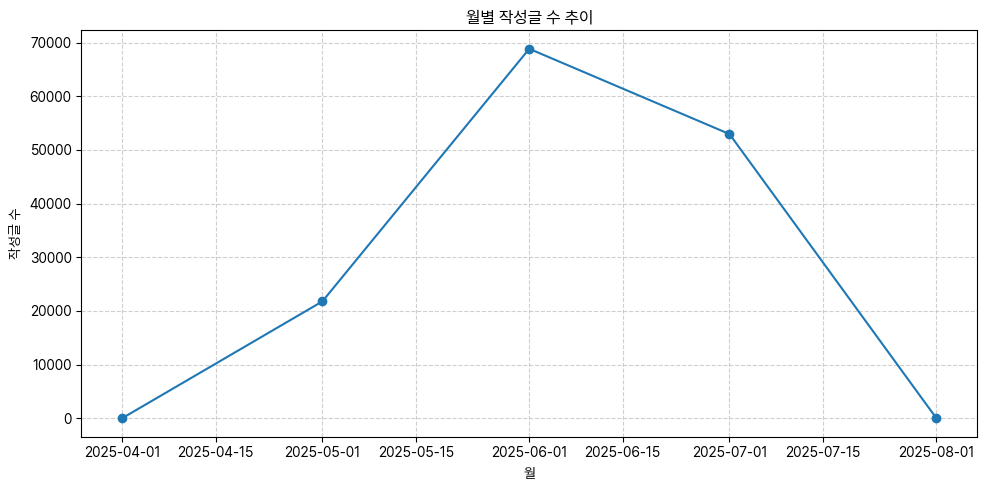

In [43]:
import pandas as pd
import matplotlib.pyplot as plt


# 월별 집계
monthly_counts = df0.groupby(df0['date'].dt.to_period('M')).size()

# 시리즈를 timestamp로 변환 (선그래프용)
monthly_counts.index = monthly_counts.index.to_timestamp()

# 시각화
plt.figure(figsize=(10,5))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title("월별 작성글 수 추이")
plt.ylabel("작성글 수")
plt.xlabel("월")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [74]:
stopwords = {
    # 닉네임/고유명사
    '갤러리잘안해요', '새대가리', '황금경쪼드리치', '레드오션', '멘대남협회장', '주딱',
    '몽쉘스', '노굼마', '모솔아다히키존못소심찐따', '둘기마왕', '조찐타', '갈고리고정',
    '아롱', '콩먹는콩벌래', '흰수염생체핫팩에이스', '숑냥', '멘딜', '회계하라','팔기견',
    '마법소녀주노','근트릿세팅', '훈련용봇','라쿤','유후','옵붕이','의문의싼아이','라쿤이',
    '쪼낙',
    
    # 웃음/유행어
    'ㅋㅋ', 'ㅎㅎ', '하셈', '개추', '입갤', '아오',
    
    # 일반적인 불용어 (조사, 대명사, 부사 등)
    '가끔', '가장', '가능', '갑자기', '같네', '같아서', '같은', '같은데', '같음', '같이',
    '거', '거의', '거임', '것', '것도', '경우', '계속', '그리고', '그게', '그걸', '그거', '그건',
    '그나마', '그냥', '그러면', '그럼', '그렇게', '그래도', '근데', '기록', '까지', '나도', '나는', '나만',
    '나오면', '나옴', '내', '내가', '너가', '너무', '느낌', '다른', '다시', '다들', '대체', '모든', '엄청',
    '더', '둘다', '딜힐', '마우가', '많아서', '많음', '맞냐', '맞음', '맨날', '먼저', '못하고', '다음', '으로',
    '못하는', '못하면', '못해서', '못함', '무조건', '무슨', '뭐가', '뭐냐', '뭐야', '뭐임', '하지', '애들이',
    '방금', '봐도', '보니까', '보면', '본인', '보고', '빨리', '사실', '사람', '상대로', '상황', '신화', '일본',
    '새끼들', '생각', '생각함', '서로', '소리', '솔직히', '순서', '시작', '시간', '실시간', '아까', '아님',
    '아니', '아니고', '아니냐', '아닌', '아닌가', '아닌데', '아니면', '아니라', '아무', '아무리', '결국',
    '아예', '아직', '없고', '없네', '없는', '없다', '없어서', '없음', '없는데', '없어', '없이', '일단','도대체',
    '영상', '오늘', '오늘은', '오히려', '우클', '왜케', '왤케', '우리', '원래', '이번', '이미', '해도','님들',
    '이미지', '이게', '이건', '이기면', '이김', '이상', '이유', '이유가', '이제', '이젠', '이거', '때문에',
    '이렇게', '있고', '있는데', '있어', '있어서', '있으면', '자기', '자꾸', '자주', '잘하', '얼마나', '쓰는','안됨',
    '잘하네', '재밌네', '저', '저거', '전에', '절대', '제대로', '제발', '좋아', '좋은', '말이', '잘하는', '언제','어차피',
    '좋은데', '지금', '지면', '진짜', '진지하게', '지가', '지들', '차라리', '차이', '참고', '해서', '역시','통나무','항상',
    '팀이', '팬텀', '팔콘은', '하나', '하네', '하고', '하니까', '하는', '하는게', '하는데', '열심히','인데',
    '하다', '하면', '하면서', '확실히', '희상', '누가', '어떻게', '어케', '어제', '했는데', '뭔가', '있는', '수준', '에서', '그래서', '이런',
    
    # 욕설/비하어
    '존나', '시발', '씨발', '새끼', '병신', '찐따', '멘대남', '새낀', '이새끼', '탱장연', '스토커', '좆같', '패작', '대가리', '배설', '미친', '이새끼들',
    '미쳤네',
    
    # 게임 관련 일반어 (너무 흔해서 의미없는 것들)
    '게임', '오버워치', '옵치', '경쟁', '매칭', '팀', '우리팀', '상대팀',
    '승률', '랭크', '티어', '시즌', '대회', '스킨', '탱커', '힐러', '딜러', 
    '상대', '애들', '많이', '바로', '요즘', '있음', '없음', '아니', '그래', 
    '니가', '제일', '섭딜', '옵붕', '에임', '그마', '라인', '다이아', '한번', 
    '빠대', '좋음', '실력', '그런', '정도', '마스터', '플레', '프로', '골드',
    '글쓴', '여자', '탱커가','팔콘이',

    # 게임 캐릭터 (분석 목적에 따라 제거할지 결정)
    '트레', '오리사', '아나', '겐지', '키리코', '주노', '디바', '해저드', '제타', '메이', '자리', '시메', 
    '하나', '프레야', '둠피', '프로퍼', '메르시', '솜브라', '로드호그', '애쉬', '솔져', '웨스터룬드', '사운드퀘이크',
    '시그마', '솔저', '자리야', '루시우', '모이라', '윈스', '리퍼', '호그','벤처','위버','캐서디','맥크리', '벤쳐',
    '파라', '소전', '브리', '위도우', '해먼드', '라마', '팔콘', '야타', '라쿤', '바티', '한조', '윈스턴', '마우', '에코'
}


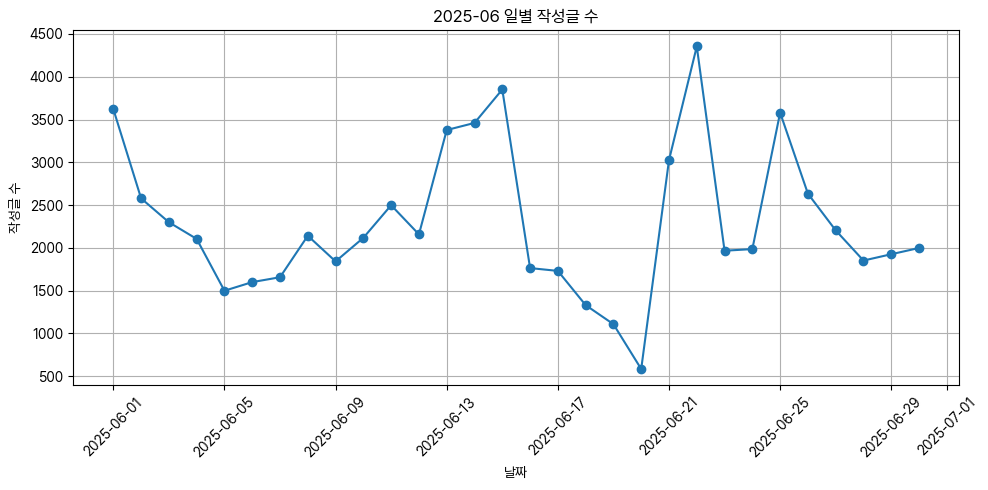

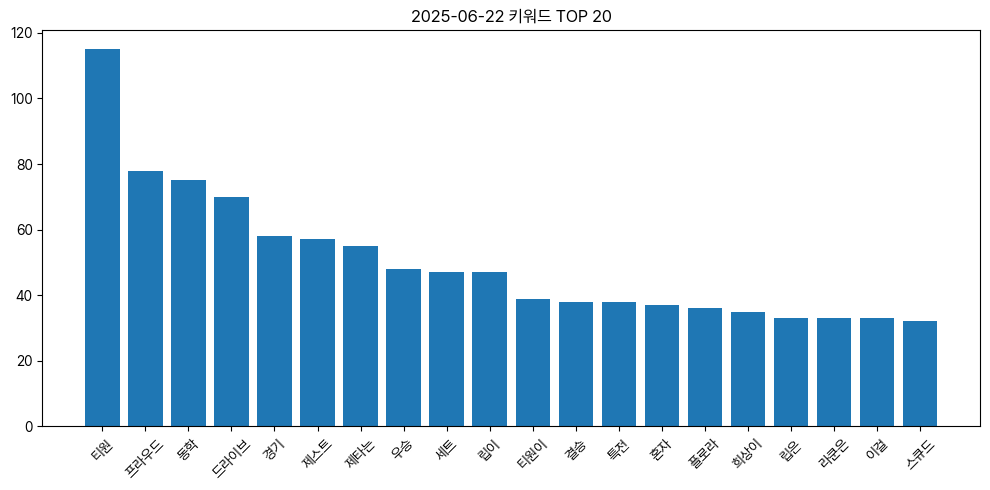

In [75]:
# 2025-06월 데이터만 필터링
target_month = '2025-06'
df_june = df0[df0['date'].dt.strftime('%Y-%m') == target_month]

# 일별 작성글 수 집계
daily_counts = df_june.groupby(df_june['date'].dt.date).size()

# 시각화
plt.figure(figsize=(10,5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title(f"{target_month} 일별 작성글 수")
plt.xlabel("날짜")
plt.ylabel("작성글 수")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 특정 날짜 키워드 보기 (예: 최대값 날짜)
peak_day = daily_counts.idxmax()
df_peak = df_june[df_june['date'].dt.date == peak_day]

from collections import Counter
import re

# 불용어
stopwords

def clean_korean(s: str) -> str:
    s = re.sub(r'[^가-힣\s]', ' ', str(s))
    return re.sub(r'\s+', ' ', s).strip()

def tokenize(text):
    tokens = clean_korean(text).split()
    return [t for t in tokens if len(t) > 1 and t not in stopwords]

# 키워드 빈도
counter = Counter()
for text in df_peak['full_text']:
    counter.update(tokenize(text))

top_keywords = counter.most_common(20)

# 시각화
words, freqs = zip(*top_keywords)
plt.figure(figsize=(10,5))
plt.bar(words, freqs)
plt.title(f"{peak_day} 키워드 TOP 20")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 오버워치 리그가 진행되었던 날로, 화제가 될 만한 플레이가 있었던 것으로 판단됨
- e스포츠 카테고리를 거르고 진행했음에도 이런 키워드가 나왔다는 것은 작성자가 카테고리를 바꾸지 않고 그냥 작성한 경우가 많은 것 같다.

In [76]:
# e스포츠 용어를 불용어로 넣고 다시 해보기

esports_words = {'티원', '프라우드', '동학', '드라이브', '경기', '제스트', '제타는', '우승', '세트', '티원이', '결승',
                 '플로라', '화상이', '립은', '라쿤은' ,'이걸', '스큐드', '희상이', '선준', '비트', '맥스', '결승전', '제타가',
                 '아이치', '프라우드가','일루전', '인큐','동학이','수라바사','점수','펠리칸','감독','립이', '인터뷰'}

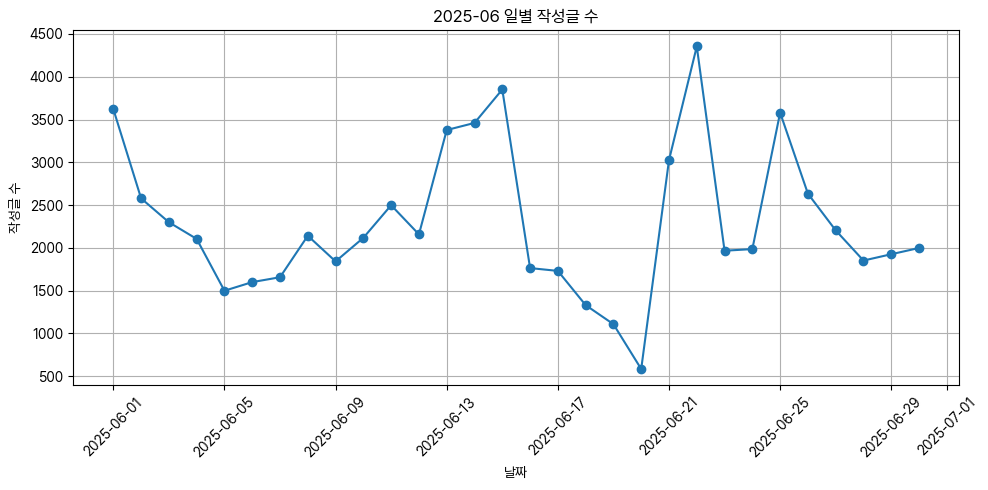

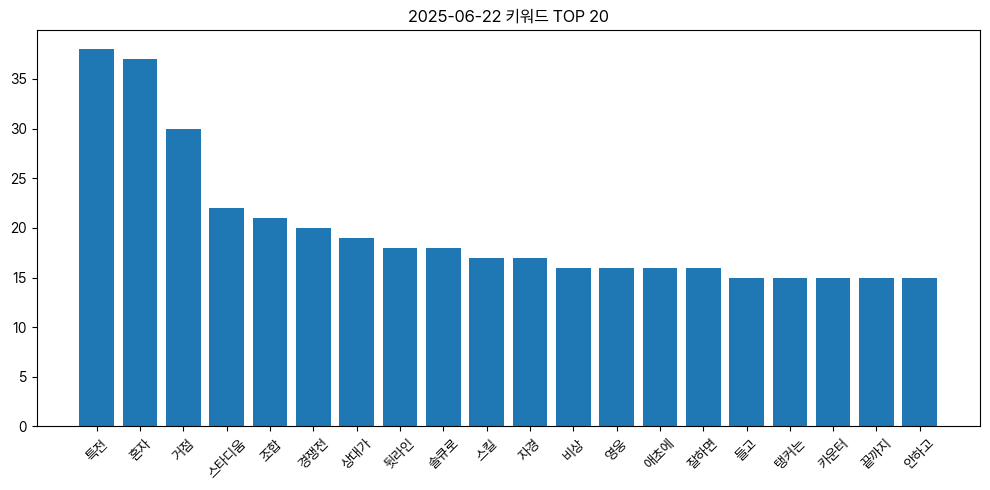

In [77]:
# 2025-06월 데이터만 필터링
target_month = '2025-06'
df_june = df0[df0['date'].dt.strftime('%Y-%m') == target_month]

# 일별 작성글 수 집계
daily_counts = df_june.groupby(df_june['date'].dt.date).size()

# 시각화
plt.figure(figsize=(10,5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title(f"{target_month} 일별 작성글 수")
plt.xlabel("날짜")
plt.ylabel("작성글 수")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 특정 날짜 키워드 보기 (예: 최대값 날짜)
peak_day = daily_counts.idxmax()
df_peak = df_june[df_june['date'].dt.date == peak_day]

from collections import Counter
import re

# 불용어
stopwords.update(esports_words)

def clean_korean(s: str) -> str:
    s = re.sub(r'[^가-힣\s]', ' ', str(s))
    return re.sub(r'\s+', ' ', s).strip()

def tokenize(text):
    tokens = clean_korean(text).split()
    return [t for t in tokens if len(t) > 1 and t not in stopwords]

# 키워드 빈도
counter = Counter()
for text in df_peak['full_text']:
    counter.update(tokenize(text))

top_keywords = counter.most_common(20)

# 시각화
words, freqs = zip(*top_keywords)
plt.figure(figsize=(10,5))
plt.bar(words, freqs)
plt.title(f"{peak_day} 키워드 TOP 20")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 이스포츠 관련 단어를 제거하고도 특성, 혼자, 거점, 스타디움, 조합, 경쟁전, 상대가, 돌진, 스킬, 자경 같은 키워드들이 많이 남아있는 것으로 보아
<br> 게임 운영방법, 전략 등을 묻는 질문성 글일 가능성이 높음
- 질문, 피드백 카테고리 제외하고 다시 진행함

In [88]:
# [댓글],[E스포츠],[질문],[피드백] 제외
df_question = connect_df[connect_df['post_type'] != '[댓글]|[⭐E스포츠]|[❓질문]|[🗣️피드백]'].copy()

# href 기준 중복 제거 (원글 단위 유지)  
df_question = df_question.drop_duplicates(subset=['href'])

print(f"원본 행 수: {len(connect_df):,}")
print(f"[댓글]|[⭐E스포츠]|[❓질문]|[🗣️피드백] 제외 후: {len(connect_df[connect_df['post_type'] != '[댓글]|[⭐E스포츠]|[❓질문]|[🗣️피드백]']):,}")
print(f"중복 제거 후: {len(df_question):,}")

원본 행 수: 525,638
[댓글]|[⭐E스포츠]|[❓질문]|[🗣️피드백] 제외 후: 525,638
중복 제거 후: 143,549


In [89]:
df1 = df_question.copy()

# 문자열 정리
df1['date'] = df1['date'].astype(str).str.strip()

# 연도 존재/누락 마스크
has_year = df1['date'].str.match(r'^\d{4}\.')

# 기준 연도 추정 (연도가 있는 행에서 최빈 연도 사용, 없으면 2025로 가정)
year_mode = (pd.to_datetime(df1.loc[has_year, 'date'],
                            format='%Y.%m.%d %H:%M:%S', errors='coerce')
               .dt.year.mode())
base_year = int(year_mode.iloc[0]) if len(year_mode) else 2025

# 연도 누락 행에 기준 연도 보강 (예: "06.15 12:47:29" -> "2025.06.15 12:47:29")
df1.loc[~has_year, 'date'] = df1.loc[~has_year, 'date'].apply(
    lambda s: f"{base_year}.{s}"
)

# 일관 포맷으로 파싱 (우선 고정 포맷 시도 → 실패분은 일반 파서로 재시도)
date_parsed = pd.to_datetime(df1['date'], format='%Y.%m.%d %H:%M:%S', errors='coerce')
fallback_mask = date_parsed.isna()
if fallback_mask.any():
    date_parsed.loc[fallback_mask] = pd.to_datetime(df1.loc[fallback_mask, 'date'], errors='coerce')

# 결과 반영 및 파생 컬럼
df1['date'] = date_parsed
df1 = df1.dropna(subset=['date']).copy()
df1['day'] = df1['date'].dt.floor('D')
df1['weekday'] = df1['date'].dt.weekday   # 0=월, 6=일
df1['hour'] = df1['date'].dt.hour

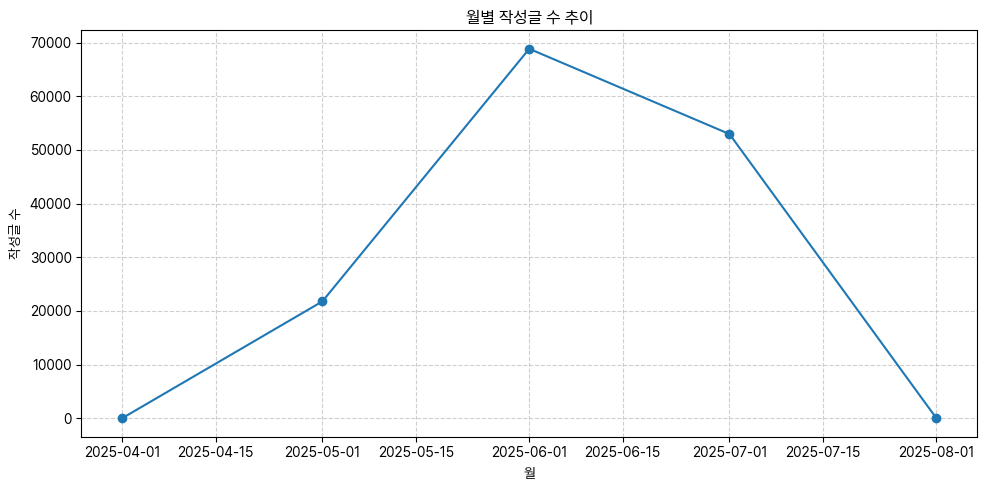

In [90]:
# 월별 집계
monthly_counts = df1.groupby(df0['date'].dt.to_period('M')).size()

# 시리즈를 timestamp로 변환 (선그래프용)
monthly_counts.index = monthly_counts.index.to_timestamp()

# 시각화
plt.figure(figsize=(10,5))
plt.plot(monthly_counts.index, monthly_counts.values, marker='o')
plt.title("월별 작성글 수 추이")
plt.ylabel("작성글 수")
plt.xlabel("월")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

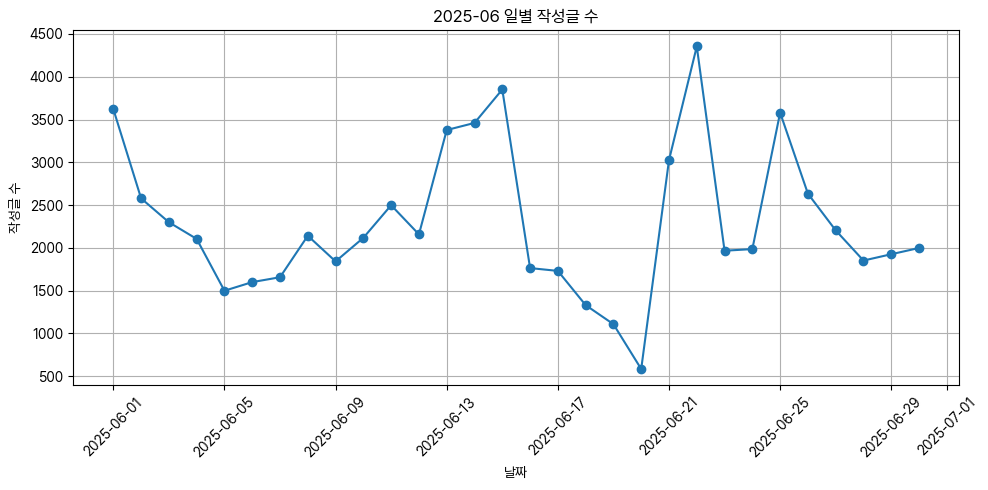

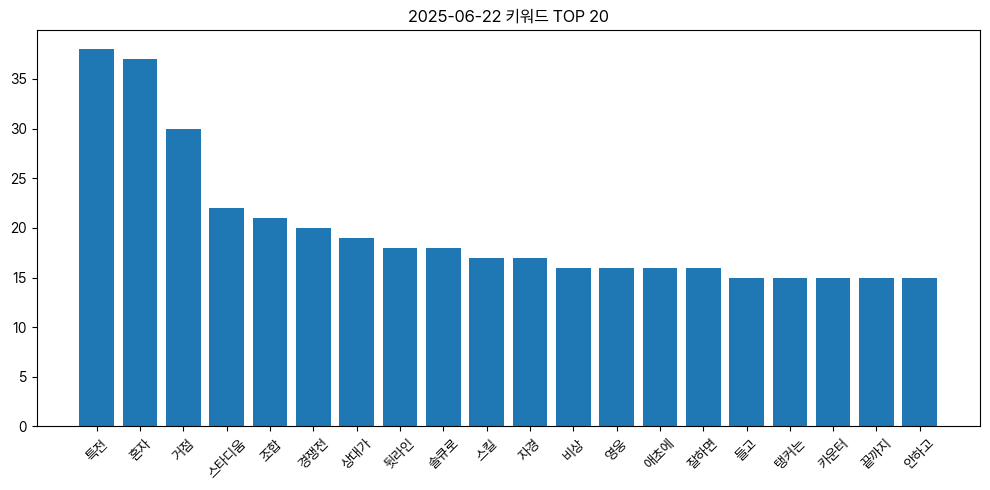

In [91]:
# 2025-06월 데이터만 필터링
target_month = '2025-06'
df_june = df1[df1['date'].dt.strftime('%Y-%m') == target_month]

# 일별 작성글 수 집계
daily_counts = df_june.groupby(df_june['date'].dt.date).size()

# 시각화
plt.figure(figsize=(10,5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title(f"{target_month} 일별 작성글 수")
plt.xlabel("날짜")
plt.ylabel("작성글 수")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# 특정 날짜 키워드 보기 (예: 최대값 날짜)
peak_day = daily_counts.idxmax()
df_peak = df_june[df_june['date'].dt.date == peak_day]

from collections import Counter
import re

# 불용어
stopwords.update(esports_words)

def clean_korean(s: str) -> str:
    s = re.sub(r'[^가-힣\s]', ' ', str(s))
    return re.sub(r'\s+', ' ', s).strip()

def tokenize(text):
    tokens = clean_korean(text).split()
    return [t for t in tokens if len(t) > 1 and t not in stopwords]

# 키워드 빈도
counter = Counter()
for text in df_peak['full_text']:
    counter.update(tokenize(text))

top_keywords = counter.most_common(20)

# 시각화
words, freqs = zip(*top_keywords)
plt.figure(figsize=(10,5))
plt.bar(words, freqs)
plt.title(f"{peak_day} 키워드 TOP 20")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- 6월 17일에 새 시즌이 시작되었었음
- 너무 초반은 패치노트 분석이나 초기 반응, 버그 발견 및 제보, 새 시즌에 적응하는 과정 등에 있어서 게시글이 뜸했을 가능성이 있음
- 5일 정도 지난 22일 쯤은 e스포츠 영향도 있지만 초반 메타가 어느 정도 잡히면서 공략법이나 조합가능성에 대한 논쟁이 늘어났을 것으로 판단됨.